# Cтруктурные, физико-химические и дескрипторы Шредингера из программы QikProp

План:
1. Построение структурных, физико-химических и дескрипторов Шредингера (QikProp)
2. Оценка корреляции дескрипторов с pIC50
3. Feature permutation на объединенных дескрипторах
4. Построение RandomForestClassifier и конесенсусной модели RF + CatBoost, визуализация первого дерева.
5. Вывод. Дескрипторы как LogP, fr_NH0 (число четвертичных аминов), MR, PSA, #rotor (Number of non-trivial (not CX3), non-hindered (not alkene, amide, small ring) rotatable bonds). 

In [1181]:
from pathlib import Path
import sys
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors
from rdkit.Chem import PandasTools
from rdkit.Chem import Draw
from rdkit.Chem import ChemicalFeatures
from rdkit import RDConfig
from rdkit.Chem.Pharm2D.SigFactory import SigFactory
from rdkit.Chem.Pharm2D import Generate
#import mols2grid
# mols2grid.useSVG=True
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG=True
from IPython.display import display, display_png
from sklearn.preprocessing import FunctionTransformer
from pandas import DataFrame
import pickle
import numpy as np
import pandas as pd
from rdkit.Chem import AllChem, Draw, DataStructs
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier, Pool, cv
from sklearn.ensemble import VotingClassifier
import sklearn.metrics as metrics
from sklearn.metrics import f1_score, accuracy_score, balanced_accuracy_score, roc_auc_score, recall_score, precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_predict, GridSearchCV
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
from matplotlib.pyplot import figure
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [1182]:
#! pip install seaborn

In [1183]:
df = PandasTools.LoadSDF('herg_smaller_right.sdf')


,canonical_smiles,molecule_chembl_id,molecule_pref_name,standard_relation,standard_type,standard_units,units,value,MW,value_nM,class,pIC50,ID,ROMol
0,O=C1NCCN1CCN1CCC(c2cn(-c3ccccc3)c3ccc(Cl)cc23)CC1,CHEMBL443476,nan,=,IC50,nM,nM,88.0,422.96,88.0,1,7.055517,,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"
1,O=C1NCCN1CCN1CCC(c2cn(C3CCCCC3)c3ccc(Cl)cc23)CC1,CHEMBL53661,nan,=,IC50,nM,nM,137.0,429.008,137.0,1,6.863279,,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"
2,CCC(CC)c1cn(-c2ccc(F)cc2)c2ccc(Cl)cc12,CHEMBL299390,nan,=,IC50,nM,nM,1480.0,315.819,1480.0,1,5.829738,,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"
3,O=C1NCCN1CCN1CC=C(c2cn(-c3ccc(F)cc3)c3ccc(Cl)c...,CHEMBL12186,nan,=,IC50,nM,nM,10.0,438.934,10.0,1,8.0,,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"
4,CC(C)(C)c1ccc2c(ccn2-c2ccc(F)cc2)c1,CHEMBL299590,nan,>,IC50,nM,nM,10000.0,267.347,10000.0,0,5.0,,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7436,CC(C)c1cc(Nc2nc(N3CCC[C@H](N)C3)ncc2C(N)=O)cc(...,CHEMBL4635883,nan,=,IC50,nM,uM,3.7,397.527,3700.0,1,5.431798,,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"
7437,COc1cc(/C=C2\CCCN3C2=NO[C@H](c2cc(F)cc(F)c2)[C...,CHEMBL4643105,nan,=,IC50,nM,nM,2007.0,464.516,2007.0,1,5.697453,,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"
7438,COc1cc(/C=C2\CCCN3C2=NO[C@H](c2cc(F)c(F)c(F)c2...,CHEMBL4634921,nan,=,IC50,nM,nM,1607.0,482.506,1607.0,1,5.793984,,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"
7439,COc1cc(C2=CC3=NO[C@H](c4cc(F)c(F)c(F)c4)CN3CCC...,CHEMBL4634696,nan,=,IC50,nM,nM,3352.0,468.479,3352.0,1,5.474696,,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"

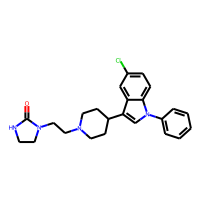
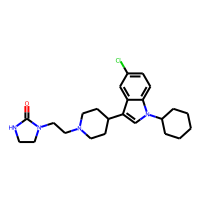
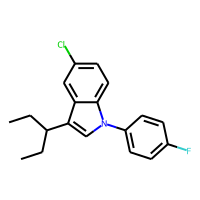
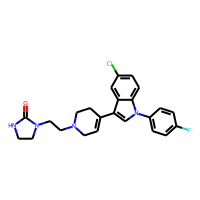
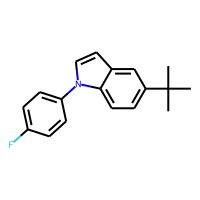
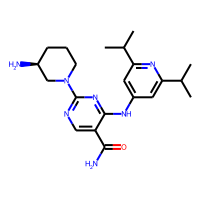
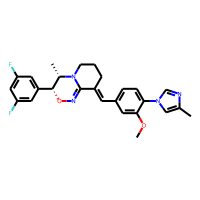
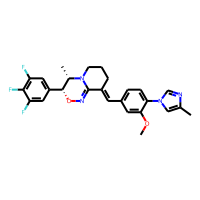
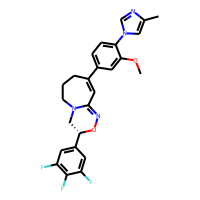
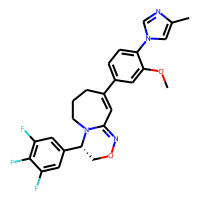

In [1184]:
df

In [1185]:
df.drop(df.loc[df['molecule_chembl_id']== 'CHEMBL209324'].index, inplace=True)

,canonical_smiles,molecule_chembl_id,molecule_pref_name,standard_relation,standard_type,standard_units,units,value,MW,value_nM,class,pIC50,ID,ROMol
0,CC(C)CN(C(=O)c1cccc(C(F)(F)F)c1Cl)[C@H]1CCNC1,CHEMBL1077638,nan,=,IC50,nM,nM,4120.0,348.796,4120.0,1,5.385103,,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"
1,CC(C)CN(C(=O)c1cc(Cl)ccc1Cl)[C@H]1CCNC1,CHEMBL1077647,nan,=,IC50,nM,nM,19800.0,315.244,19800.0,0,4.703335,,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"
2,CC(C)CN(C(=O)c1cccc(Cl)c1F)[C@H]1CCNC1,CHEMBL1078073,nan,>,IC50,nM,nM,10000.0,298.789,10000.0,0,5.0,,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"
3,CC(C)CN(C(=O)c1cccc(F)c1C(F)(F)F)[C@H]1CCNC1,CHEMBL1078074,nan,>,IC50,nM,nM,10000.0,332.341,10000.0,0,5.0,,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"
4,Cc1c(Cl)cccc1C(=O)N(CC(C)C)[C@H]1CCNC1,CHEMBL1078162,nan,=,IC50,nM,nM,52400.0,294.826,52400.0,0,4.280669,,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7435,Brc1cnc2nc(N3CCN4CCC3CC4)oc2c1,CHEMBL611369,nan,=,IC50,nM,nM,2300.0,323.194,2300.0,1,5.638272,,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"
7436,Cc1cc[n+]([O-])c(C)c1C(=O)N1CCC(C)(N2CCC(N(Cc3...,CHEMBL61536,nan,=,IC50,nM,uM,0.55,512.698,550.0,1,6.259637,,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"
7437,Cc1cccc(C)c1C(=O)N1CCC(C)(N2CCC(N(c3ccccc3)c3c...,CHEMBL62152,nan,=,IC50,nM,uM,0.15,481.684,150.0,1,6.823909,,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"
7438,Nc1nc2ccc(SC(F)(F)F)cc2s1,CHEMBL95463,nan,=,IC50,nM,uM,10.0,250.27,10000.0,1,5.0,,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"

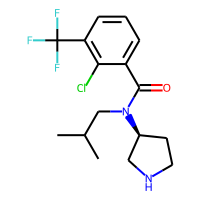
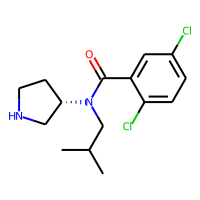
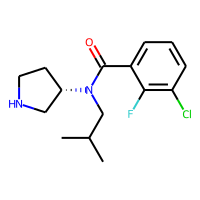
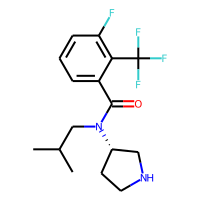
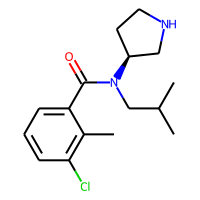
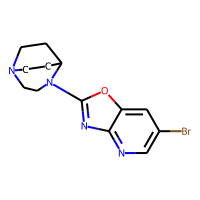
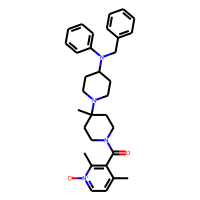
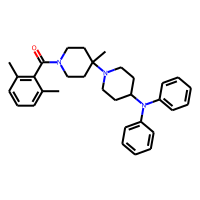
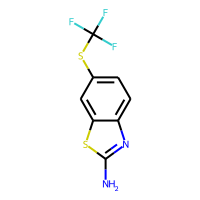
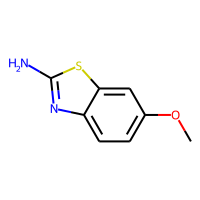

In [1186]:
df = df.sort_values(by=['molecule_chembl_id'])
df.reset_index(drop=True, inplace=True)
df

In [1187]:
df_val = pd.read_csv('herg_val_names.csv', sep = ",", engine='python')

In [1188]:
def standardize_smiles(df, col_smiles):
    logs = 0
    mols = []
    for i in df[col_smiles]:    
        mol = Chem.MolFromSmiles(i)
        if mol is not None:
            mols.append(mol)
        else:
            logs+=1
            print(i)
    print(f"Errors: {logs}")
    df["ROMol"] = mols
    return df

In [1189]:
df_val = standardize_smiles(df_val, "canonical_smiles")


Errors: 0


In [1190]:
# создаем словарь из дескриторов структуры (Lipinski module)
ConstDescriptors = {"HeavyAtomCount": Descriptors.HeavyAtomCount,
                    "NHOHCount": Descriptors.NHOHCount,
                    "NOCount": Descriptors.NOCount,
                    "NumHAcceptors": Descriptors.NumHAcceptors,
                    "NumHDonors": Descriptors.NumHDonors,
                    "NumHeteroatoms": Descriptors.NumHeteroatoms,
                    "NumRotatableBonds": Descriptors.NumRotatableBonds,
                    "NumValenceElectrons": Descriptors.NumValenceElectrons,
                    "NumAromaticRings": Descriptors.NumAromaticRings,
                    "NumAliphaticHeterocycles": Descriptors.NumAliphaticHeterocycles,
                    "RingCount": Descriptors.RingCount,
                    "fr_Al_COO": Descriptors.fr_Al_COO,
                    "fr_Al_OH": Descriptors.fr_Al_OH,
                    "fr_amide": Descriptors.fr_amide,
                    "fr_NH0": Descriptors.fr_NH0,
                    "fr_alkyl_halide": Descriptors.fr_alkyl_halide,
                    "fr_hdrzone": Descriptors.fr_hdrzone,
                    "fr_thiazole": Descriptors.fr_thiazole,
                    "CalcFractionCSP3": rdMolDescriptors.CalcFractionCSP3
                   }

# создаем словарь из физико-химических дескрипторов                            
PhisChemDescriptors = {"MW": Descriptors.MolWt,
                       "LogP": Descriptors.MolLogP,
                       "TPSA": Descriptors.TPSA}

# объединяем все дескрипторы в один словарь
descriptors = {}
descriptors.update(ConstDescriptors)
descriptors.update(PhisChemDescriptors)
print(f"Количество дескрипторов в словаре: {len(descriptors)}")


# функция для генерации дескрипторов из молекул
def mol_dsc_calc(mols): 
    return DataFrame({k: f(m) for k, f in descriptors.items()} 
             for m in np.array(mols).ravel())

# оформляем sklearn трансформер для использования в конвеерном моделировании (sklearn Pipeline)
descriptors_transformer = FunctionTransformer(mol_dsc_calc, validate=False)

Количество дескрипторов в словаре: 22


In [1191]:
X = descriptors_transformer.transform(df["ROMol"])
df_val_d = descriptors_transformer.transform(df_val["ROMol"])

In [1192]:
df_logp = pd.concat([df,X['LogP']],axis=1)

In [1193]:
df_all = pd.concat([df,X],axis=1)

In [1194]:
def stat(df, activity, param):
    c,me,std,mi,procent1, procent2, procent3, ma = df.loc[df['class'] == activity][param].describe().round(4)
    if activity == '1':
        act = "blocker"
    else:
        act = "non-blocker"
    print(f'Class activity = {activity},{act}\ncount={c}\nmean={me}\nstd={std}\nmin={mi}\n25%={procent1}\n50%={procent2}\n75%={procent3}\nmax={ma}')

Посмотрим на стаститическое распределение для блокаторов и неблокаторов по LogP

In [1195]:
res = stat(df_logp, '1', 'LogP')

Class activity = 1,blocker
count=3539.0
mean=4.1409
std=1.2796
min=-0.9015
25%=3.2952
50%=4.0302
75%=4.8453
max=9.8391


In [1196]:
res2 = stat(df_logp, '0', "LogP")

Class activity = 0,non-blocker
count=3901.0
mean=3.457
std=1.3723
min=-4.0489
25%=2.5718
50%=3.3532
75%=4.2289
max=9.2313


In [1197]:
def to_one_class(x, name, types):
    # приводит соединения к одному классу, поскольку формат csv/sdf не сохраняет класс объекта.
    x_res = x[name].astype({name: types})
    return x_res

In [1198]:
df_all["pIC50"] = to_one_class(df_all, name = "pIC50", types = float)

In [1199]:
df_all1 = df_all.iloc[:, -22:]

In [1200]:
df_all1["pIC50"] = df["pIC50"]
df_all1["value_nM"] = df["value_nM"]
df_all1

,HeavyAtomCount,NHOHCount,NOCount,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,NumAliphaticHeterocycles,RingCount,fr_Al_COO,fr_Al_OH,fr_amide,fr_NH0,fr_alkyl_halide,fr_hdrzone,fr_thiazole,CalcFractionCSP3,MW,LogP,TPSA,pIC50,value_nM
0,23,1,3,2,1,7,4,128,1,1,2,0,0,1,1,3,0,0,0.562500,348.796,3.81890,32.34,5.385103,4120.0
1,20,1,3,2,1,5,4,110,1,1,2,0,0,1,1,0,0,0,0.533333,315.244,3.45350,32.34,4.703335,19800.0
2,20,1,3,2,1,5,4,110,1,1,2,0,0,1,1,0,0,0,0.533333,298.789,2.93920,32.34,5.0,10000.0
3,23,1,3,2,1,7,4,128,1,1,2,0,0,1,1,3,0,0,0.562500,332.341,3.30460,32.34,5.0,10000.0
4,20,1,3,2,1,4,4,110,1,1,2,0,0,1,1,0,0,0,0.562500,294.826,3.10852,32.34,4.280669,52400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7435,19,0,5,5,0,6,1,100,2,3,5,0,0,0,4,0,0,0,0.538462,323.194,2.26970,45.40,5.638272,2300.0
7436,38,0,6,4,0,6,6,200,3,2,5,0,0,1,4,0,0,0,0.437500,512.698,5.10274,53.73,6.259637,550.0
7437,36,0,4,3,0,4,5,188,3,2,5,0,0,1,3,0,0,0,0.406250,481.684,6.60084,26.79,6.823909,150.0
7438,15,2,2,4,1,7,1,80,2,0,2,0,0,0,1,3,0,1,0.125000,250.270,3.49040,38.91,5.0,10000.0


In [1201]:
df_all1["pIC50"] = pd.to_numeric(df_all1["pIC50"])
df_all1["value_nM"] = pd.to_numeric(df_all1["value_nM"])

In [1202]:
df_all1.to_csv("descriptors_struct_phys.csv", encoding='utf-8', index=False)

In [1203]:
corr_df_spearman = df_all1.corr(method="spearman")
corr_df_spearman[np.abs(corr_df_spearman['pIC50']) > 0.1]['pIC50']

NHOHCount           -0.152958
NOCount             -0.210235
NumHAcceptors       -0.156971
NumHDonors          -0.158732
NumHeteroatoms      -0.191347
NumRotatableBonds    0.107413
fr_amide            -0.155824
LogP                 0.317120
TPSA                -0.257218
pIC50                1.000000
value_nM            -1.000000
Name: pIC50, dtype: float64

Единственная корреляция - с LogP  и TPSA

* LogP = Predicted octanol/water partition coefficient
* TPSA = topological polar surface area (TPSA) of a molecule is defined as the surface sum over all polar atoms or molecules, primarily oxygen and nitrogen, also including their attached hydrogen atoms.

<Figure size 1080x720 with 0 Axes>

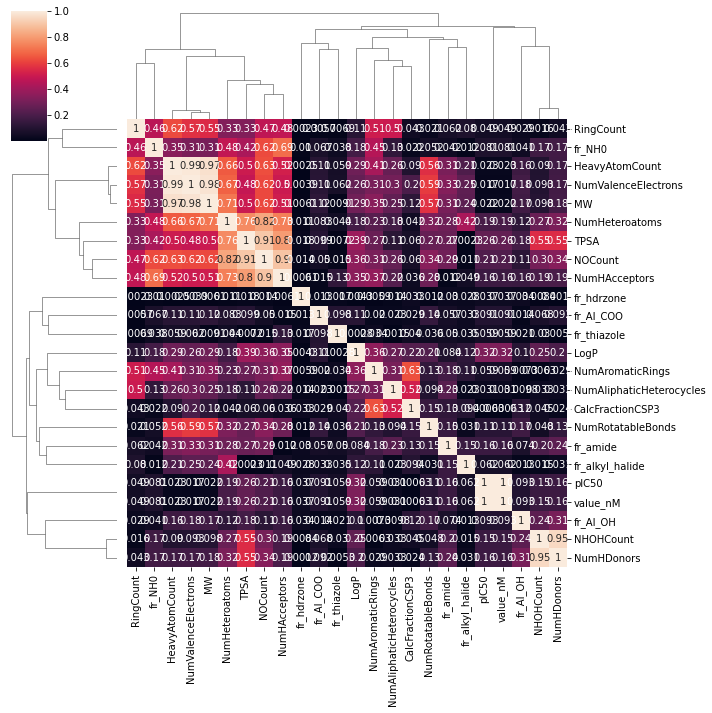

In [1204]:

plt.figure(figsize=(15, 10))

sns.clustermap(np.abs(corr_df_spearman), annot = True)
plt.savefig('spearman_corr.png', dpi=300)

In [1205]:
res1 = np.abs(corr_df_spearman)

In [1206]:
def delete_correlations(df, res, level):
    np.fill_diagonal(res.values, 0)
    index = []
    count = 0
    Dict = {}
    for k in range(len(res.values)):
        m = -1
        for i in res.values[k]:
            m += 1
            if i > level:
                count += 1
                mean1 = np.mean(res.values[k])
                mean2 = np.mean(res.values[m])
                
                if mean1 > mean2:
                    index.append(k)
                    Dict.update( {df.columns[k] : df.columns[m]+f" corr = {i}"} )
                else:
                    index.append(m)
                    Dict.update( {df.columns[m] : df.columns[k]+f" corr = {i}"} )
    index = list(dict.fromkeys(index))
    df_res = df.drop(df.columns[index],axis=1)
    print(f"Deleted fearures are: {df.columns[index]}") 
    return(Dict, index, df_res)
    
        #print(i)

In [1207]:
Dict, index, X_norm_SS_without_corr = delete_correlations(df_all1, res1, 0.95)

Deleted fearures are: Index(['HeavyAtomCount', 'NumHDonors', 'NumValenceElectrons', 'value_nM',
       'pIC50'],
      dtype='object')


In [1208]:
Dict

{'HeavyAtomCount': 'MW corr = 0.9718391836665886',
 'NumHDonors': 'NHOHCount corr = 0.9519520118007961',
 'NumValenceElectrons': 'MW corr = 0.976629566532602',
 'value_nM': 'pIC50 corr = 1.0',
 'pIC50': 'value_nM corr = 1.0'}

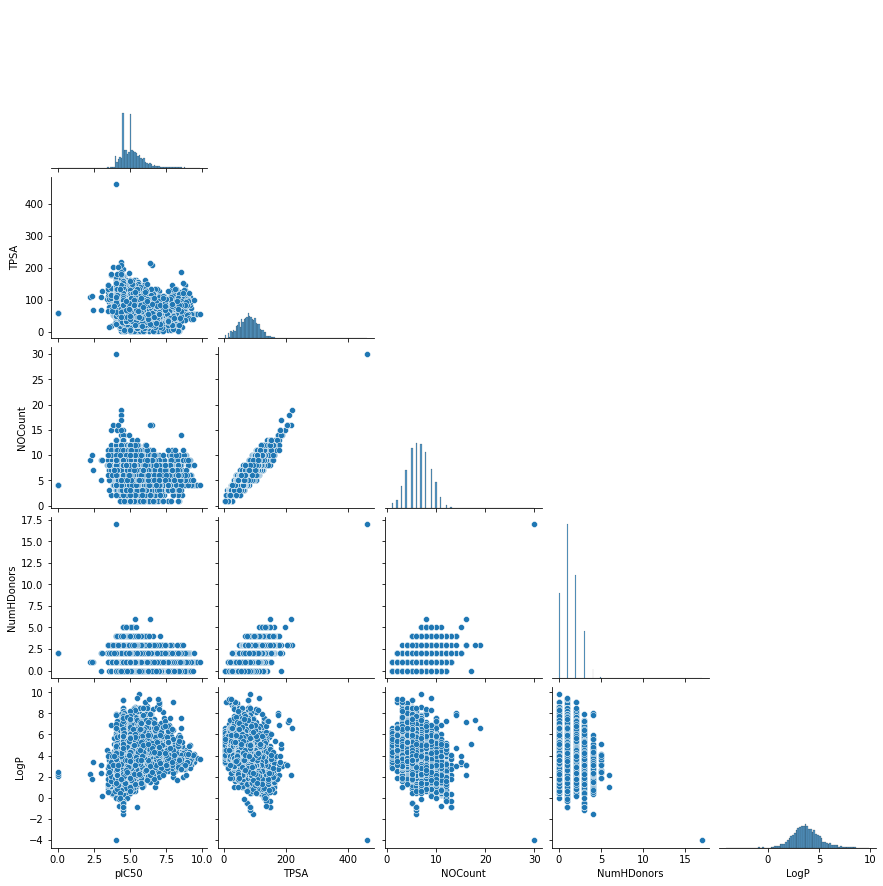

In [1209]:
sns.pairplot(df_all1[["pIC50", "TPSA", "NOCount", "NumHDonors","LogP"]], corner=True)

значимой корреляции pIC50 с  LogP не видно

Попробуем комбинации:

In [1210]:
df_all1["LogP_NumRotatableBonds_NumAromaticRings"] = df_all1[["LogP","NumRotatableBonds","NumAromaticRings"]].sum(axis=1)
df_all1["TPSA_NOCount"] =df_all1[["TPSA","NOCount"]].sum(axis=1)
df_all1["LogP_MW"] = df_all1["LogP"]*df_all1["MW"]

In [1211]:
df_test = df_all1[["pIC50",
                  "LogP_NumRotatableBonds_NumAromaticRings",
                  "TPSA_NOCount",
                     "LogP_MW"
                 ]]

In [1212]:
corr_df_test_pearson = df_test.corr(method="pearson")
corr_df_test_pearson[np.abs(corr_df_test_pearson["pIC50"]) > 0.1]["pIC50"]

pIC50                                      1.000000
LogP_NumRotatableBonds_NumAromaticRings    0.196654
TPSA_NOCount                              -0.220505
LogP_MW                                    0.195140
Name: pIC50, dtype: float64

In [1213]:
# ! conda install seaborn -y

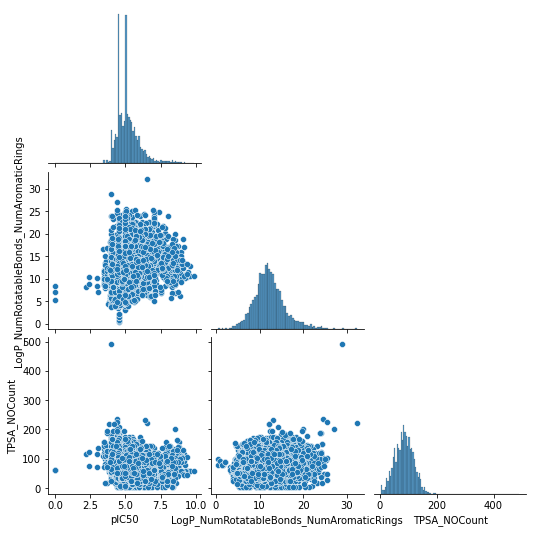

In [1214]:
sns.pairplot(df_all1[["pIC50", "LogP_NumRotatableBonds_NumAromaticRings", "TPSA_NOCount"]], corner=True)

Улучшения при линейной комбинациии признаков не наблюдается

# Дескрипторы Шредингера ( QikProp)

In [1215]:
def read_csv_with_nan(csv_file):
    from csv import reader
    # open file in read mode
    with open(csv_file, 'r') as read_obj:
        # pass the file object to reader() to get the reader object
        csv_reader = reader(read_obj)
        # Iterate over each row in the csv using reader object
        a = []
        for row in csv_reader:
            a.append(row)
            # row variable is a list that represents a row in csv
            # print(row)
    d_schroedinger = pd.DataFrame(a)
    d_schroedinger.columns = d_schroedinger.iloc[0]
    d_schroedinger = d_schroedinger[1:]
    d_schroedinger = d_schroedinger.loc[:, d_schroedinger.columns.notnull()]
    d_schroedinger.reset_index(drop=True, inplace=True)
    return d_schroedinger

In [1216]:
d_schroedinger = read_csv_with_nan("qikprop_7k.csv")


In [1217]:
d_schroedinger

,molecule,#stars,#amine,#amidine,#acid,#amide,#rotor,#rtvFG,CNS,mol_MW,dipole,SASA,FOSA,FISA,PISA,WPSA,volume,donorHB,accptHB,dip^2/V,ACxDN^.5/SA,glob,QPpolrz,QPlogPC16,QPlogPoct,QPlogPw,QPlogPo/w,QPlogS,CIQPlogS,QPlogHERG,QPPCaco,QPlogBB,QPPMDCK,QPlogKp,IP(eV),EA(eV),#metab,QPlogKhsa,HumanOralAbsorption,PercentHumanOralAbsorption,SAfluorine,SAamideO,PSA,#NandO,RuleOfFive,#ringatoms,#in34,#in56,#noncon,#nonHatm,RuleOfThree,Jm
0,CHEMBL12713,1,1,0,0,0,3,0,1,440.947,7.294,761.664,293.212,83.169,266.744,118.538,1357.996,1.000,4.000,0.0391812,0.0052517,0.7786351,48.814,13.861,20.711,8.717,5.802,-7.488,-6.655,-7.112,401.892,0.158,911.323,-3.887,8.287,0.737,2,1.406,1,94.566,47.013,0.000,53.329,5,1,26,0,26,7,31,1,0.000
1,CHEMBL1108,0,1,0,0,0,5,0,1,379.433,5.335,688.755,177.594,125.727,338.396,47.039,1213.372,1.000,6.000,0.0234580,0.0087114,0.7987846,42.426,12.714,19.294,10.822,3.501,-4.768,-4.546,-7.128,158.684,-0.538,135.450,-4.227,8.729,0.849,4,0.516,3,86.833,47.039,0.000,77.075,5,0,21,0,21,3,28,0,0.000
2,CHEMBL2368925,0,1,0,0,0,2,1,1,324.379,4.883,586.577,257.421,112.191,216.965,0.000,1029.591,0.000,5.000,0.0231582,0.0000000,0.8406521,35.838,10.085,14.703,7.854,2.528,-3.170,-3.210,-5.871,213.250,-0.217,103.000,-4.693,8.605,0.334,2,0.184,3,83.429,0.000,0.000,75.722,5,0,20,0,20,9,24,0,0.004
3,CHEMBL6966,0,1,0,0,0,14,0,1,454.608,6.826,678.150,557.072,36.750,84.328,0.000,1416.270,0.000,6.500,0.0328995,0.0000000,0.8993662,42.341,12.123,17.312,5.489,4.027,-4.280,-6.384,-4.289,1107.391,-0.185,611.102,-2.618,8.388,-0.121,6,0.396,3,100.000,0.000,0.000,51.629,6,0,12,0,12,0,33,0,0.747
4,CHEMBL1107,3,1,0,0,0,11,0,2,500.430,1.992,801.252,373.323,13.430,164.009,250.490,1471.548,1.000,3.700,0.0026955,0.0046178,0.7808701,47.241,13.670,19.421,5.625,7.526,-7.605,-7.751,-6.586,1842.638,0.767,10000.000,-2.196,8.868,1.494,2,1.449,1,100.000,117.620,0.000,20.369,2,2,14,0,14,0,33,1,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7874,CHEMBL4635883,0,1,0,0,0,6,0,-1,397.522,5.262,704.539,470.667,152.295,81.577,0.000,1299.014,4.000,6.500,0.0213186,0.0184518,0.8172141,42.759,12.848,23.568,13.943,2.738,-4.207,-4.185,-5.605,88.836,-0.920,39.974,-5.525,8.579,0.541,5,0.457,3,77.852,0.000,0.000,114.703,8,0,18,0,18,5,29,0,0.000
7875,CHEMBL4643105,1,0,0,0,0,3,0,1,464.514,5.551,801.623,374.206,54.017,279.466,93.934,1443.612,0.000,5.450,0.0213431,0.0000000,0.7705993,52.362,13.563,20.778,8.656,6.371,-8.475,-7.704,-6.577,3045.511,0.007,5391.414,-1.243,8.959,1.083,5,1.224,1,100.000,93.934,0.000,46.398,6,1,27,0,27,5,34,1,0.000
7876,CHEMBL4634921,2,0,0,0,0,3,0,1,482.504,5.016,808.996,374.210,54.007,250.154,130.624,1458.107,0.000,5.450,0.0172566,0.0000000,0.7686795,52.662,13.267,20.956,8.487,6.571,-8.775,-8.086,-6.468,3046.129,0.094,8566.089,-1.346,8.990,1.135,4,1.266,1,100.000,130.624,0.000,46.395,6,1,27,0,27,5,35,1,0.000
7877,CHEMBL4634696,1,0,0,0,0,1,0,1,468.478,7.765,779.532,338.619,67.409,242.861,130.644,1402.407,0.000,5.450,0.0429939,0.0000000,0.7772849,51.648,12.734,21.102,8.899,6.107,-8.542,-7.549,-6.294,2273.341,0.080,6244.929,-1.810,9.032,1.180,4,1.189,1,100.000,130.644,0.000,49.142,6,1,28,0,23,5,34,1,0.000


In [1218]:
d_schroedinger = d_schroedinger[d_schroedinger['molecule'].isin(df['molecule_chembl_id'])]

In [1219]:
d_schroedinger = d_schroedinger.sort_values(by=['molecule'])
d_schroedinger.reset_index(drop=True, inplace=True)
d_schroedinger

,molecule,#stars,#amine,#amidine,#acid,#amide,#rotor,#rtvFG,CNS,mol_MW,dipole,SASA,FOSA,FISA,PISA,WPSA,volume,donorHB,accptHB,dip^2/V,ACxDN^.5/SA,glob,QPpolrz,QPlogPC16,QPlogPoct,QPlogPw,QPlogPo/w,QPlogS,CIQPlogS,QPlogHERG,QPPCaco,QPlogBB,QPPMDCK,QPlogKp,IP(eV),EA(eV),#metab,QPlogKhsa,HumanOralAbsorption,PercentHumanOralAbsorption,SAfluorine,SAamideO,PSA,#NandO,RuleOfFive,#ringatoms,#in34,#in56,#noncon,#nonHatm,RuleOfThree,Jm
0,CHEMBL1077638,0,1,0,0,0,4,0,2,348.795,4.503,556.626,270.702,54.033,95.102,136.790,1008.850,1.000,4.500,0.0201019,0.0080844,0.8739484,32.560,8.470,14.928,7.136,3.476,-3.541,-3.856,-4.751,759.289,0.585,2281.905,-3.859,9.216,0.830,1,0.339,3,100.000,106.720,0.000,36.352,3,0,11,0,11,4,23,0,0.014
1,CHEMBL1077647,1,1,0,0,0,4,0,2,315.242,3.837,541.102,272.846,50.024,100.553,117.679,965.639,1.000,4.500,0.0152441,0.0083164,0.8731635,30.883,9.380,14.152,7.101,3.166,-3.187,-3.177,-4.790,828.740,0.572,1971.044,-3.766,9.155,0.539,0,0.224,3,100.000,0.000,0.000,36.488,3,0,11,0,11,4,20,0,0.035
2,CHEMBL1078073,1,1,0,0,0,4,0,2,298.787,4.618,529.731,275.614,53.803,109.554,90.761,939.754,1.000,4.500,0.0226910,0.0084949,0.8758958,29.933,8.743,13.821,7.152,2.887,-2.872,-2.846,-4.789,763.113,0.476,1283.840,-3.804,9.150,0.587,0,0.156,3,95.441,22.391,0.000,37.281,3,0,11,0,11,4,20,0,0.063
3,CHEMBL1078074,0,1,0,0,0,4,0,2,332.340,6.091,572.580,306.041,45.894,108.949,111.696,1012.778,1.000,4.500,0.0366278,0.0078592,0.8518019,32.849,8.227,15.042,7.204,3.469,-3.712,-3.522,-5.176,906.950,0.573,2014.895,-3.660,8.934,0.943,1,0.341,3,100.000,111.696,0.000,34.625,3,0,11,0,11,4,23,0,0.014
4,CHEMBL1078162,0,1,0,0,0,4,0,2,294.823,4.098,532.222,315.309,49.921,105.348,61.643,966.874,1.000,4.500,0.0173696,0.0084551,0.8884899,30.978,9.100,13.990,7.092,2.973,-2.788,-2.767,-4.565,830.611,0.451,974.521,-3.747,9.179,0.242,1,0.233,3,96.603,0.000,0.000,36.719,3,0,11,0,11,4,20,0,0.086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7435,CHEMBL611369,0,1,0,0,0,0,0,2,323.192,4.539,501.630,257.112,50.988,115.706,77.824,857.984,0.000,5.500,0.0240086,0.0000000,0.8704976,29.288,7.929,12.728,7.505,1.767,-1.963,-2.783,-4.905,811.491,0.704,1165.463,-4.114,8.778,0.665,2,-0.363,3,89.360,0.000,0.000,41.964,5,0,18,0,15,7,19,0,0.271
7436,CHEMBL61536,3,1,0,0,0,5,0,1,512.694,8.241,851.089,376.095,68.961,406.033,0.000,1640.500,0.000,6.000,0.0413967,0.0000000,0.7903886,60.166,16.824,24.007,9.805,6.547,-7.170,-7.280,-7.586,548.076,-0.075,285.724,-2.943,8.733,0.903,6,1.563,1,88.382,0.000,0.000,52.714,6,2,30,0,30,10,38,1,0.000
7437,CHEMBL62152,3,1,0,0,0,4,0,1,481.680,4.979,819.456,342.920,26.791,449.745,0.000,1568.861,0.000,4.500,0.0158041,0.0000000,0.7968240,58.359,16.160,22.111,8.483,7.153,-7.519,-7.317,-7.691,1376.390,0.440,773.024,-2.107,8.152,0.022,4,1.799,1,100.000,0.000,0.000,30.046,4,1,30,0,30,10,36,1,0.000
7438,CHEMBL95463,1,0,0,0,0,2,0,1,250.256,6.673,416.514,0.983,89.014,123.806,202.711,668.610,2.000,2.000,0.0665938,0.0067907,0.8878044,20.502,6.218,12.024,6.698,2.418,-3.497,-3.864,-3.938,1418.345,0.187,9308.097,-2.532,8.981,1.551,1,-0.136,3,100.000,115.026,0.000,39.662,2,0,9,0,9,0,15,0,0.234


In [1220]:
d_schroedinger

,molecule,#stars,#amine,#amidine,#acid,#amide,#rotor,#rtvFG,CNS,mol_MW,dipole,SASA,FOSA,FISA,PISA,WPSA,volume,donorHB,accptHB,dip^2/V,ACxDN^.5/SA,glob,QPpolrz,QPlogPC16,QPlogPoct,QPlogPw,QPlogPo/w,QPlogS,CIQPlogS,QPlogHERG,QPPCaco,QPlogBB,QPPMDCK,QPlogKp,IP(eV),EA(eV),#metab,QPlogKhsa,HumanOralAbsorption,PercentHumanOralAbsorption,SAfluorine,SAamideO,PSA,#NandO,RuleOfFive,#ringatoms,#in34,#in56,#noncon,#nonHatm,RuleOfThree,Jm
0,CHEMBL1077638,0,1,0,0,0,4,0,2,348.795,4.503,556.626,270.702,54.033,95.102,136.790,1008.850,1.000,4.500,0.0201019,0.0080844,0.8739484,32.560,8.470,14.928,7.136,3.476,-3.541,-3.856,-4.751,759.289,0.585,2281.905,-3.859,9.216,0.830,1,0.339,3,100.000,106.720,0.000,36.352,3,0,11,0,11,4,23,0,0.014
1,CHEMBL1077647,1,1,0,0,0,4,0,2,315.242,3.837,541.102,272.846,50.024,100.553,117.679,965.639,1.000,4.500,0.0152441,0.0083164,0.8731635,30.883,9.380,14.152,7.101,3.166,-3.187,-3.177,-4.790,828.740,0.572,1971.044,-3.766,9.155,0.539,0,0.224,3,100.000,0.000,0.000,36.488,3,0,11,0,11,4,20,0,0.035
2,CHEMBL1078073,1,1,0,0,0,4,0,2,298.787,4.618,529.731,275.614,53.803,109.554,90.761,939.754,1.000,4.500,0.0226910,0.0084949,0.8758958,29.933,8.743,13.821,7.152,2.887,-2.872,-2.846,-4.789,763.113,0.476,1283.840,-3.804,9.150,0.587,0,0.156,3,95.441,22.391,0.000,37.281,3,0,11,0,11,4,20,0,0.063
3,CHEMBL1078074,0,1,0,0,0,4,0,2,332.340,6.091,572.580,306.041,45.894,108.949,111.696,1012.778,1.000,4.500,0.0366278,0.0078592,0.8518019,32.849,8.227,15.042,7.204,3.469,-3.712,-3.522,-5.176,906.950,0.573,2014.895,-3.660,8.934,0.943,1,0.341,3,100.000,111.696,0.000,34.625,3,0,11,0,11,4,23,0,0.014
4,CHEMBL1078162,0,1,0,0,0,4,0,2,294.823,4.098,532.222,315.309,49.921,105.348,61.643,966.874,1.000,4.500,0.0173696,0.0084551,0.8884899,30.978,9.100,13.990,7.092,2.973,-2.788,-2.767,-4.565,830.611,0.451,974.521,-3.747,9.179,0.242,1,0.233,3,96.603,0.000,0.000,36.719,3,0,11,0,11,4,20,0,0.086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7435,CHEMBL611369,0,1,0,0,0,0,0,2,323.192,4.539,501.630,257.112,50.988,115.706,77.824,857.984,0.000,5.500,0.0240086,0.0000000,0.8704976,29.288,7.929,12.728,7.505,1.767,-1.963,-2.783,-4.905,811.491,0.704,1165.463,-4.114,8.778,0.665,2,-0.363,3,89.360,0.000,0.000,41.964,5,0,18,0,15,7,19,0,0.271
7436,CHEMBL61536,3,1,0,0,0,5,0,1,512.694,8.241,851.089,376.095,68.961,406.033,0.000,1640.500,0.000,6.000,0.0413967,0.0000000,0.7903886,60.166,16.824,24.007,9.805,6.547,-7.170,-7.280,-7.586,548.076,-0.075,285.724,-2.943,8.733,0.903,6,1.563,1,88.382,0.000,0.000,52.714,6,2,30,0,30,10,38,1,0.000
7437,CHEMBL62152,3,1,0,0,0,4,0,1,481.680,4.979,819.456,342.920,26.791,449.745,0.000,1568.861,0.000,4.500,0.0158041,0.0000000,0.7968240,58.359,16.160,22.111,8.483,7.153,-7.519,-7.317,-7.691,1376.390,0.440,773.024,-2.107,8.152,0.022,4,1.799,1,100.000,0.000,0.000,30.046,4,1,30,0,30,10,36,1,0.000
7438,CHEMBL95463,1,0,0,0,0,2,0,1,250.256,6.673,416.514,0.983,89.014,123.806,202.711,668.610,2.000,2.000,0.0665938,0.0067907,0.8878044,20.502,6.218,12.024,6.698,2.418,-3.497,-3.864,-3.938,1418.345,0.187,9308.097,-2.532,8.981,1.551,1,-0.136,3,100.000,115.026,0.000,39.662,2,0,9,0,9,0,15,0,0.234


In [1221]:
df_all = pd.concat([X,d_schroedinger],axis=1)

In [1222]:
df_all = pd.concat([df_all,df["class"]],axis=1)


In [1223]:
df_all['QPlogKhsa'] = pd.to_numeric(df_all['QPlogKhsa'], downcast="float")

In [1224]:
res = stat(df_all, '1', 'QPlogKhsa')

Class activity = 1,blocker
count=3511.0
mean=0.6076
std=0.5209
min=-1.384
25%=0.2845
50%=0.579
75%=0.913
max=2.93


In [1225]:
res = stat(df_all, '0', 'QPlogKhsa')

Class activity = 0,non-blocker
count=3896.0
mean=0.3215
std=0.5182
min=-3.032
25%=-0.003
50%=0.312
75%=0.618
max=2.116


In [1226]:
df_all

,HeavyAtomCount,NHOHCount,NOCount,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,NumAliphaticHeterocycles,RingCount,fr_Al_COO,fr_Al_OH,fr_amide,fr_NH0,fr_alkyl_halide,fr_hdrzone,fr_thiazole,CalcFractionCSP3,MW,LogP,TPSA,molecule,#stars,#amine,#amidine,#acid,#amide,#rotor,#rtvFG,CNS,mol_MW,dipole,SASA,FOSA,FISA,PISA,WPSA,volume,donorHB,accptHB,dip^2/V,ACxDN^.5/SA,glob,QPpolrz,QPlogPC16,QPlogPoct,QPlogPw,QPlogPo/w,QPlogS,CIQPlogS,QPlogHERG,QPPCaco,QPlogBB,QPPMDCK,QPlogKp,IP(eV),EA(eV),#metab,QPlogKhsa,HumanOralAbsorption,PercentHumanOralAbsorption,SAfluorine,SAamideO,PSA,#NandO,RuleOfFive,#ringatoms,#in34,#in56,#noncon,#nonHatm,RuleOfThree,Jm,class
0,23,1,3,2,1,7,4,128,1,1,2,0,0,1,1,3,0,0,0.562500,348.796,3.81890,32.34,CHEMBL1077638,0,1,0,0,0,4,0,2,348.795,4.503,556.626,270.702,54.033,95.102,136.790,1008.850,1.000,4.500,0.0201019,0.0080844,0.8739484,32.560,8.470,14.928,7.136,3.476,-3.541,-3.856,-4.751,759.289,0.585,2281.905,-3.859,9.216,0.830,1,0.339,3,100.000,106.720,0.000,36.352,3,0,11,0,11,4,23,0,0.014,1
1,20,1,3,2,1,5,4,110,1,1,2,0,0,1,1,0,0,0,0.533333,315.244,3.45350,32.34,CHEMBL1077647,1,1,0,0,0,4,0,2,315.242,3.837,541.102,272.846,50.024,100.553,117.679,965.639,1.000,4.500,0.0152441,0.0083164,0.8731635,30.883,9.380,14.152,7.101,3.166,-3.187,-3.177,-4.790,828.740,0.572,1971.044,-3.766,9.155,0.539,0,0.224,3,100.000,0.000,0.000,36.488,3,0,11,0,11,4,20,0,0.035,0
2,20,1,3,2,1,5,4,110,1,1,2,0,0,1,1,0,0,0,0.533333,298.789,2.93920,32.34,CHEMBL1078073,1,1,0,0,0,4,0,2,298.787,4.618,529.731,275.614,53.803,109.554,90.761,939.754,1.000,4.500,0.0226910,0.0084949,0.8758958,29.933,8.743,13.821,7.152,2.887,-2.872,-2.846,-4.789,763.113,0.476,1283.840,-3.804,9.150,0.587,0,0.156,3,95.441,22.391,0.000,37.281,3,0,11,0,11,4,20,0,0.063,0
3,23,1,3,2,1,7,4,128,1,1,2,0,0,1,1,3,0,0,0.562500,332.341,3.30460,32.34,CHEMBL1078074,0,1,0,0,0,4,0,2,332.340,6.091,572.580,306.041,45.894,108.949,111.696,1012.778,1.000,4.500,0.0366278,0.0078592,0.8518019,32.849,8.227,15.042,7.204,3.469,-3.712,-3.522,-5.176,906.950,0.573,2014.895,-3.660,8.934,0.943,1,0.341,3,100.000,111.696,0.000,34.625,3,0,11,0,11,4,23,0,0.014,0
4,20,1,3,2,1,4,4,110,1,1,2,0,0,1,1,0,0,0,0.562500,294.826,3.10852,32.34,CHEMBL1078162,0,1,0,0,0,4,0,2,294.823,4.098,532.222,315.309,49.921,105.348,61.643,966.874,1.000,4.500,0.0173696,0.0084551,0.8884899,30.978,9.100,13.990,7.092,2.973,-2.788,-2.767,-4.565,830.611,0.451,974.521,-3.747,9.179,0.242,1,0.233,3,96.603,0.000,0.000,36.719,3,0,11,0,11,4,20,0,0.086,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7435,19,0,5,5,0,6,1,100,2,3,5,0,0,0,4,0,0,0,0.538462,323.194,2.26970,45.40,CHEMBL611369,0,1,0,0,0,0,0,2,323.192,4.539,501.630,257.112,50.988,115.706,77.824,857.984,0.000,5.500,0.0240086,0.0000000,0.8704976,29.288,7.929,12.728,7.505,1.767,-1.963,-2.783,-4.905,811.491,0.704,1165.463,-4.114,8.778,0.665,2,-0.363,3,89.360,0.000,0.000,41.964,5,0,18,0,15,7,19,0,0.271,1
7436,38,0,6,4,0,6,6,200,3,2,5,0,0,1,4,0,0,0,0.437500,512.698,5.10274,53.73,CHEMBL61536,3,1,0,0,0,5,0,1,512.694,8.241,851.089,376.095,68.961,406.033,0.000,1640.500,0.000,6.000,0.0413967,0.0000000,0.7903886,60.166,16.824,24.007,9.805,6.547,-7.170,-7.280,-7.586,548.076,-0.075,285.724,-2.943,8.733,0.903,6,1.563,1,88.382,0.000,0.000,52.714,6,2,30,0,30,10,38,1,0.000,1
7437,36,0,4,3,0,4,5,188,3,2,5,0,0,1,3,0,0,0,0.406250,481.684,6.60084,26.79,CHEMBL62152,3,1,0,0,0,4,0,1,481.680,4.979,819.456,342.920,26.791,449.745,0.000,1568.861,0.000,4.500,0.0158041,0.0000000,0.7968240,58.359,16.160,22.111,8.483,7.153,-7.519,-7.317,-7.691,1376.390,0.440,773.024,-2.107,8.152,0.022,4,1.799,1,100.000,0.000,0.000,30.046,4,1,30,0,30,10,36,1,0.000,1
7438,15,2,2,4,1,7,1,80,2,0,2,0,0,0,1,3,0,1,0.125000,250.270,3.49040,38.91,CH

In [1227]:
df_all = pd.concat([df_all,df["pIC50"]],axis=1)
df_all

,HeavyAtomCount,NHOHCount,NOCount,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,NumAliphaticHeterocycles,RingCount,fr_Al_COO,fr_Al_OH,fr_amide,fr_NH0,fr_alkyl_halide,fr_hdrzone,fr_thiazole,CalcFractionCSP3,MW,LogP,TPSA,molecule,#stars,#amine,#amidine,#acid,#amide,#rotor,#rtvFG,CNS,mol_MW,dipole,SASA,FOSA,FISA,PISA,WPSA,volume,donorHB,accptHB,dip^2/V,ACxDN^.5/SA,glob,QPpolrz,QPlogPC16,QPlogPoct,QPlogPw,QPlogPo/w,QPlogS,CIQPlogS,QPlogHERG,QPPCaco,QPlogBB,QPPMDCK,QPlogKp,IP(eV),EA(eV),#metab,QPlogKhsa,HumanOralAbsorption,PercentHumanOralAbsorption,SAfluorine,SAamideO,PSA,#NandO,RuleOfFive,#ringatoms,#in34,#in56,#noncon,#nonHatm,RuleOfThree,Jm,class,pIC50
0,23,1,3,2,1,7,4,128,1,1,2,0,0,1,1,3,0,0,0.562500,348.796,3.81890,32.34,CHEMBL1077638,0,1,0,0,0,4,0,2,348.795,4.503,556.626,270.702,54.033,95.102,136.790,1008.850,1.000,4.500,0.0201019,0.0080844,0.8739484,32.560,8.470,14.928,7.136,3.476,-3.541,-3.856,-4.751,759.289,0.585,2281.905,-3.859,9.216,0.830,1,0.339,3,100.000,106.720,0.000,36.352,3,0,11,0,11,4,23,0,0.014,1,5.385103
1,20,1,3,2,1,5,4,110,1,1,2,0,0,1,1,0,0,0,0.533333,315.244,3.45350,32.34,CHEMBL1077647,1,1,0,0,0,4,0,2,315.242,3.837,541.102,272.846,50.024,100.553,117.679,965.639,1.000,4.500,0.0152441,0.0083164,0.8731635,30.883,9.380,14.152,7.101,3.166,-3.187,-3.177,-4.790,828.740,0.572,1971.044,-3.766,9.155,0.539,0,0.224,3,100.000,0.000,0.000,36.488,3,0,11,0,11,4,20,0,0.035,0,4.703335
2,20,1,3,2,1,5,4,110,1,1,2,0,0,1,1,0,0,0,0.533333,298.789,2.93920,32.34,CHEMBL1078073,1,1,0,0,0,4,0,2,298.787,4.618,529.731,275.614,53.803,109.554,90.761,939.754,1.000,4.500,0.0226910,0.0084949,0.8758958,29.933,8.743,13.821,7.152,2.887,-2.872,-2.846,-4.789,763.113,0.476,1283.840,-3.804,9.150,0.587,0,0.156,3,95.441,22.391,0.000,37.281,3,0,11,0,11,4,20,0,0.063,0,5.0
3,23,1,3,2,1,7,4,128,1,1,2,0,0,1,1,3,0,0,0.562500,332.341,3.30460,32.34,CHEMBL1078074,0,1,0,0,0,4,0,2,332.340,6.091,572.580,306.041,45.894,108.949,111.696,1012.778,1.000,4.500,0.0366278,0.0078592,0.8518019,32.849,8.227,15.042,7.204,3.469,-3.712,-3.522,-5.176,906.950,0.573,2014.895,-3.660,8.934,0.943,1,0.341,3,100.000,111.696,0.000,34.625,3,0,11,0,11,4,23,0,0.014,0,5.0
4,20,1,3,2,1,4,4,110,1,1,2,0,0,1,1,0,0,0,0.562500,294.826,3.10852,32.34,CHEMBL1078162,0,1,0,0,0,4,0,2,294.823,4.098,532.222,315.309,49.921,105.348,61.643,966.874,1.000,4.500,0.0173696,0.0084551,0.8884899,30.978,9.100,13.990,7.092,2.973,-2.788,-2.767,-4.565,830.611,0.451,974.521,-3.747,9.179,0.242,1,0.233,3,96.603,0.000,0.000,36.719,3,0,11,0,11,4,20,0,0.086,0,4.280669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7435,19,0,5,5,0,6,1,100,2,3,5,0,0,0,4,0,0,0,0.538462,323.194,2.26970,45.40,CHEMBL611369,0,1,0,0,0,0,0,2,323.192,4.539,501.630,257.112,50.988,115.706,77.824,857.984,0.000,5.500,0.0240086,0.0000000,0.8704976,29.288,7.929,12.728,7.505,1.767,-1.963,-2.783,-4.905,811.491,0.704,1165.463,-4.114,8.778,0.665,2,-0.363,3,89.360,0.000,0.000,41.964,5,0,18,0,15,7,19,0,0.271,1,5.638272
7436,38,0,6,4,0,6,6,200,3,2,5,0,0,1,4,0,0,0,0.437500,512.698,5.10274,53.73,CHEMBL61536,3,1,0,0,0,5,0,1,512.694,8.241,851.089,376.095,68.961,406.033,0.000,1640.500,0.000,6.000,0.0413967,0.0000000,0.7903886,60.166,16.824,24.007,9.805,6.547,-7.170,-7.280,-7.586,548.076,-0.075,285.724,-2.943,8.733,0.903,6,1.563,1,88.382,0.000,0.000,52.714,6,2,30,0,30,10,38,1,0.000,1,6.259637
7437,36,0,4,3,0,4,5,188,3,2,5,0,0,1,3,0,0,0,0.406250,481.684,6.60084,26.79,CHEMBL62152,3,1,0,0,0,4,0,1,481.680,4.979,819.456,342.920,26.791,449.745,0.000,1568.861,0.000,4.500,0.0158041,0.0000000,0.7968240,58.359,16.160,22.111,8.483,7.153,-7.519,-7.317,-7.691,1376.390,0.440,773.024,-2.107,8.152,0.022,4,1.799,1,100.000,0.000,0.000,30.046,4,1,30,0,30,10,36,1,0.000,1,6.823909
7438

In [1228]:
df_all.isna().sum().sum()

33

In [1229]:
df_all = df_all[df_all["#stars"] != ""]

In [1230]:
df_all

,HeavyAtomCount,NHOHCount,NOCount,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,NumAliphaticHeterocycles,RingCount,fr_Al_COO,fr_Al_OH,fr_amide,fr_NH0,fr_alkyl_halide,fr_hdrzone,fr_thiazole,CalcFractionCSP3,MW,LogP,TPSA,molecule,#stars,#amine,#amidine,#acid,#amide,#rotor,#rtvFG,CNS,mol_MW,dipole,SASA,FOSA,FISA,PISA,WPSA,volume,donorHB,accptHB,dip^2/V,ACxDN^.5/SA,glob,QPpolrz,QPlogPC16,QPlogPoct,QPlogPw,QPlogPo/w,QPlogS,CIQPlogS,QPlogHERG,QPPCaco,QPlogBB,QPPMDCK,QPlogKp,IP(eV),EA(eV),#metab,QPlogKhsa,HumanOralAbsorption,PercentHumanOralAbsorption,SAfluorine,SAamideO,PSA,#NandO,RuleOfFive,#ringatoms,#in34,#in56,#noncon,#nonHatm,RuleOfThree,Jm,class,pIC50
0,23,1,3,2,1,7,4,128,1,1,2,0,0,1,1,3,0,0,0.562500,348.796,3.81890,32.34,CHEMBL1077638,0,1,0,0,0,4,0,2,348.795,4.503,556.626,270.702,54.033,95.102,136.790,1008.850,1.000,4.500,0.0201019,0.0080844,0.8739484,32.560,8.470,14.928,7.136,3.476,-3.541,-3.856,-4.751,759.289,0.585,2281.905,-3.859,9.216,0.830,1,0.339,3,100.000,106.720,0.000,36.352,3,0,11,0,11,4,23,0,0.014,1,5.385103
1,20,1,3,2,1,5,4,110,1,1,2,0,0,1,1,0,0,0,0.533333,315.244,3.45350,32.34,CHEMBL1077647,1,1,0,0,0,4,0,2,315.242,3.837,541.102,272.846,50.024,100.553,117.679,965.639,1.000,4.500,0.0152441,0.0083164,0.8731635,30.883,9.380,14.152,7.101,3.166,-3.187,-3.177,-4.790,828.740,0.572,1971.044,-3.766,9.155,0.539,0,0.224,3,100.000,0.000,0.000,36.488,3,0,11,0,11,4,20,0,0.035,0,4.703335
2,20,1,3,2,1,5,4,110,1,1,2,0,0,1,1,0,0,0,0.533333,298.789,2.93920,32.34,CHEMBL1078073,1,1,0,0,0,4,0,2,298.787,4.618,529.731,275.614,53.803,109.554,90.761,939.754,1.000,4.500,0.0226910,0.0084949,0.8758958,29.933,8.743,13.821,7.152,2.887,-2.872,-2.846,-4.789,763.113,0.476,1283.840,-3.804,9.150,0.587,0,0.156,3,95.441,22.391,0.000,37.281,3,0,11,0,11,4,20,0,0.063,0,5.0
3,23,1,3,2,1,7,4,128,1,1,2,0,0,1,1,3,0,0,0.562500,332.341,3.30460,32.34,CHEMBL1078074,0,1,0,0,0,4,0,2,332.340,6.091,572.580,306.041,45.894,108.949,111.696,1012.778,1.000,4.500,0.0366278,0.0078592,0.8518019,32.849,8.227,15.042,7.204,3.469,-3.712,-3.522,-5.176,906.950,0.573,2014.895,-3.660,8.934,0.943,1,0.341,3,100.000,111.696,0.000,34.625,3,0,11,0,11,4,23,0,0.014,0,5.0
4,20,1,3,2,1,4,4,110,1,1,2,0,0,1,1,0,0,0,0.562500,294.826,3.10852,32.34,CHEMBL1078162,0,1,0,0,0,4,0,2,294.823,4.098,532.222,315.309,49.921,105.348,61.643,966.874,1.000,4.500,0.0173696,0.0084551,0.8884899,30.978,9.100,13.990,7.092,2.973,-2.788,-2.767,-4.565,830.611,0.451,974.521,-3.747,9.179,0.242,1,0.233,3,96.603,0.000,0.000,36.719,3,0,11,0,11,4,20,0,0.086,0,4.280669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7435,19,0,5,5,0,6,1,100,2,3,5,0,0,0,4,0,0,0,0.538462,323.194,2.26970,45.40,CHEMBL611369,0,1,0,0,0,0,0,2,323.192,4.539,501.630,257.112,50.988,115.706,77.824,857.984,0.000,5.500,0.0240086,0.0000000,0.8704976,29.288,7.929,12.728,7.505,1.767,-1.963,-2.783,-4.905,811.491,0.704,1165.463,-4.114,8.778,0.665,2,-0.363,3,89.360,0.000,0.000,41.964,5,0,18,0,15,7,19,0,0.271,1,5.638272
7436,38,0,6,4,0,6,6,200,3,2,5,0,0,1,4,0,0,0,0.437500,512.698,5.10274,53.73,CHEMBL61536,3,1,0,0,0,5,0,1,512.694,8.241,851.089,376.095,68.961,406.033,0.000,1640.500,0.000,6.000,0.0413967,0.0000000,0.7903886,60.166,16.824,24.007,9.805,6.547,-7.170,-7.280,-7.586,548.076,-0.075,285.724,-2.943,8.733,0.903,6,1.563,1,88.382,0.000,0.000,52.714,6,2,30,0,30,10,38,1,0.000,1,6.259637
7437,36,0,4,3,0,4,5,188,3,2,5,0,0,1,3,0,0,0,0.406250,481.684,6.60084,26.79,CHEMBL62152,3,1,0,0,0,4,0,1,481.680,4.979,819.456,342.920,26.791,449.745,0.000,1568.861,0.000,4.500,0.0158041,0.0000000,0.7968240,58.359,16.160,22.111,8.483,7.153,-7.519,-7.317,-7.691,1376.390,0.440,773.024,-2.107,8.152,0.022,4,1.799,1,100.000,0.000,0.000,30.046,4,1,30,0,30,10,36,1,0.000,1,6.823909
7438

Сохраним дескрипторы

In [1231]:
df_all.to_csv("d_schroed_phys_chem_7407.csv", encoding='utf-8', index=False)

In [1232]:
df_all.dtypes

HeavyAtomCount     int64
NHOHCount          int64
NOCount            int64
NumHAcceptors      int64
NumHDonors         int64
                   ...  
#nonHatm          object
RuleOfThree       object
Jm                object
class             object
pIC50             object
Length: 76, dtype: object

In [1233]:
smiles = df_all["molecule"]
del df_all["molecule"]

In [1234]:
#pd.set_option('display.max_rows', 60)
#pd.set_option('display.max_columns', None)

In [1235]:
df_all = df_all.apply(pd.to_numeric)

In [1236]:
df_all.dtypes

HeavyAtomCount      int64
NHOHCount           int64
NOCount             int64
NumHAcceptors       int64
NumHDonors          int64
                   ...   
#nonHatm            int64
RuleOfThree         int64
Jm                float64
class               int64
pIC50             float64
Length: 75, dtype: object

In [1237]:
df_all1 = df_all.drop(["QPlogHERG", "#nonHatm", "QPpolrz", "#NandO", "TPSA", "QPlogPC16", "SAamideO", "CNS", "dip^2/V", "PercentHumanOralAbsorption", "volume", "SASA", "QPlogPoct", 'NumValenceElectrons', "NumHeteroatoms", "FISA", "QPlogBB", "QPlogKhsa", "QPlogKp", "QPlogPw"], axis = 1)

In [1254]:
df_all1 = df_all1.astype({"class": int, "pIC50": float})
corr_df_spearman = np.abs(df_all1.corr(method="spearman"))


In [1255]:
corr_df_spearman.loc['QPlogS', 'LogP']

0.6446974685322537

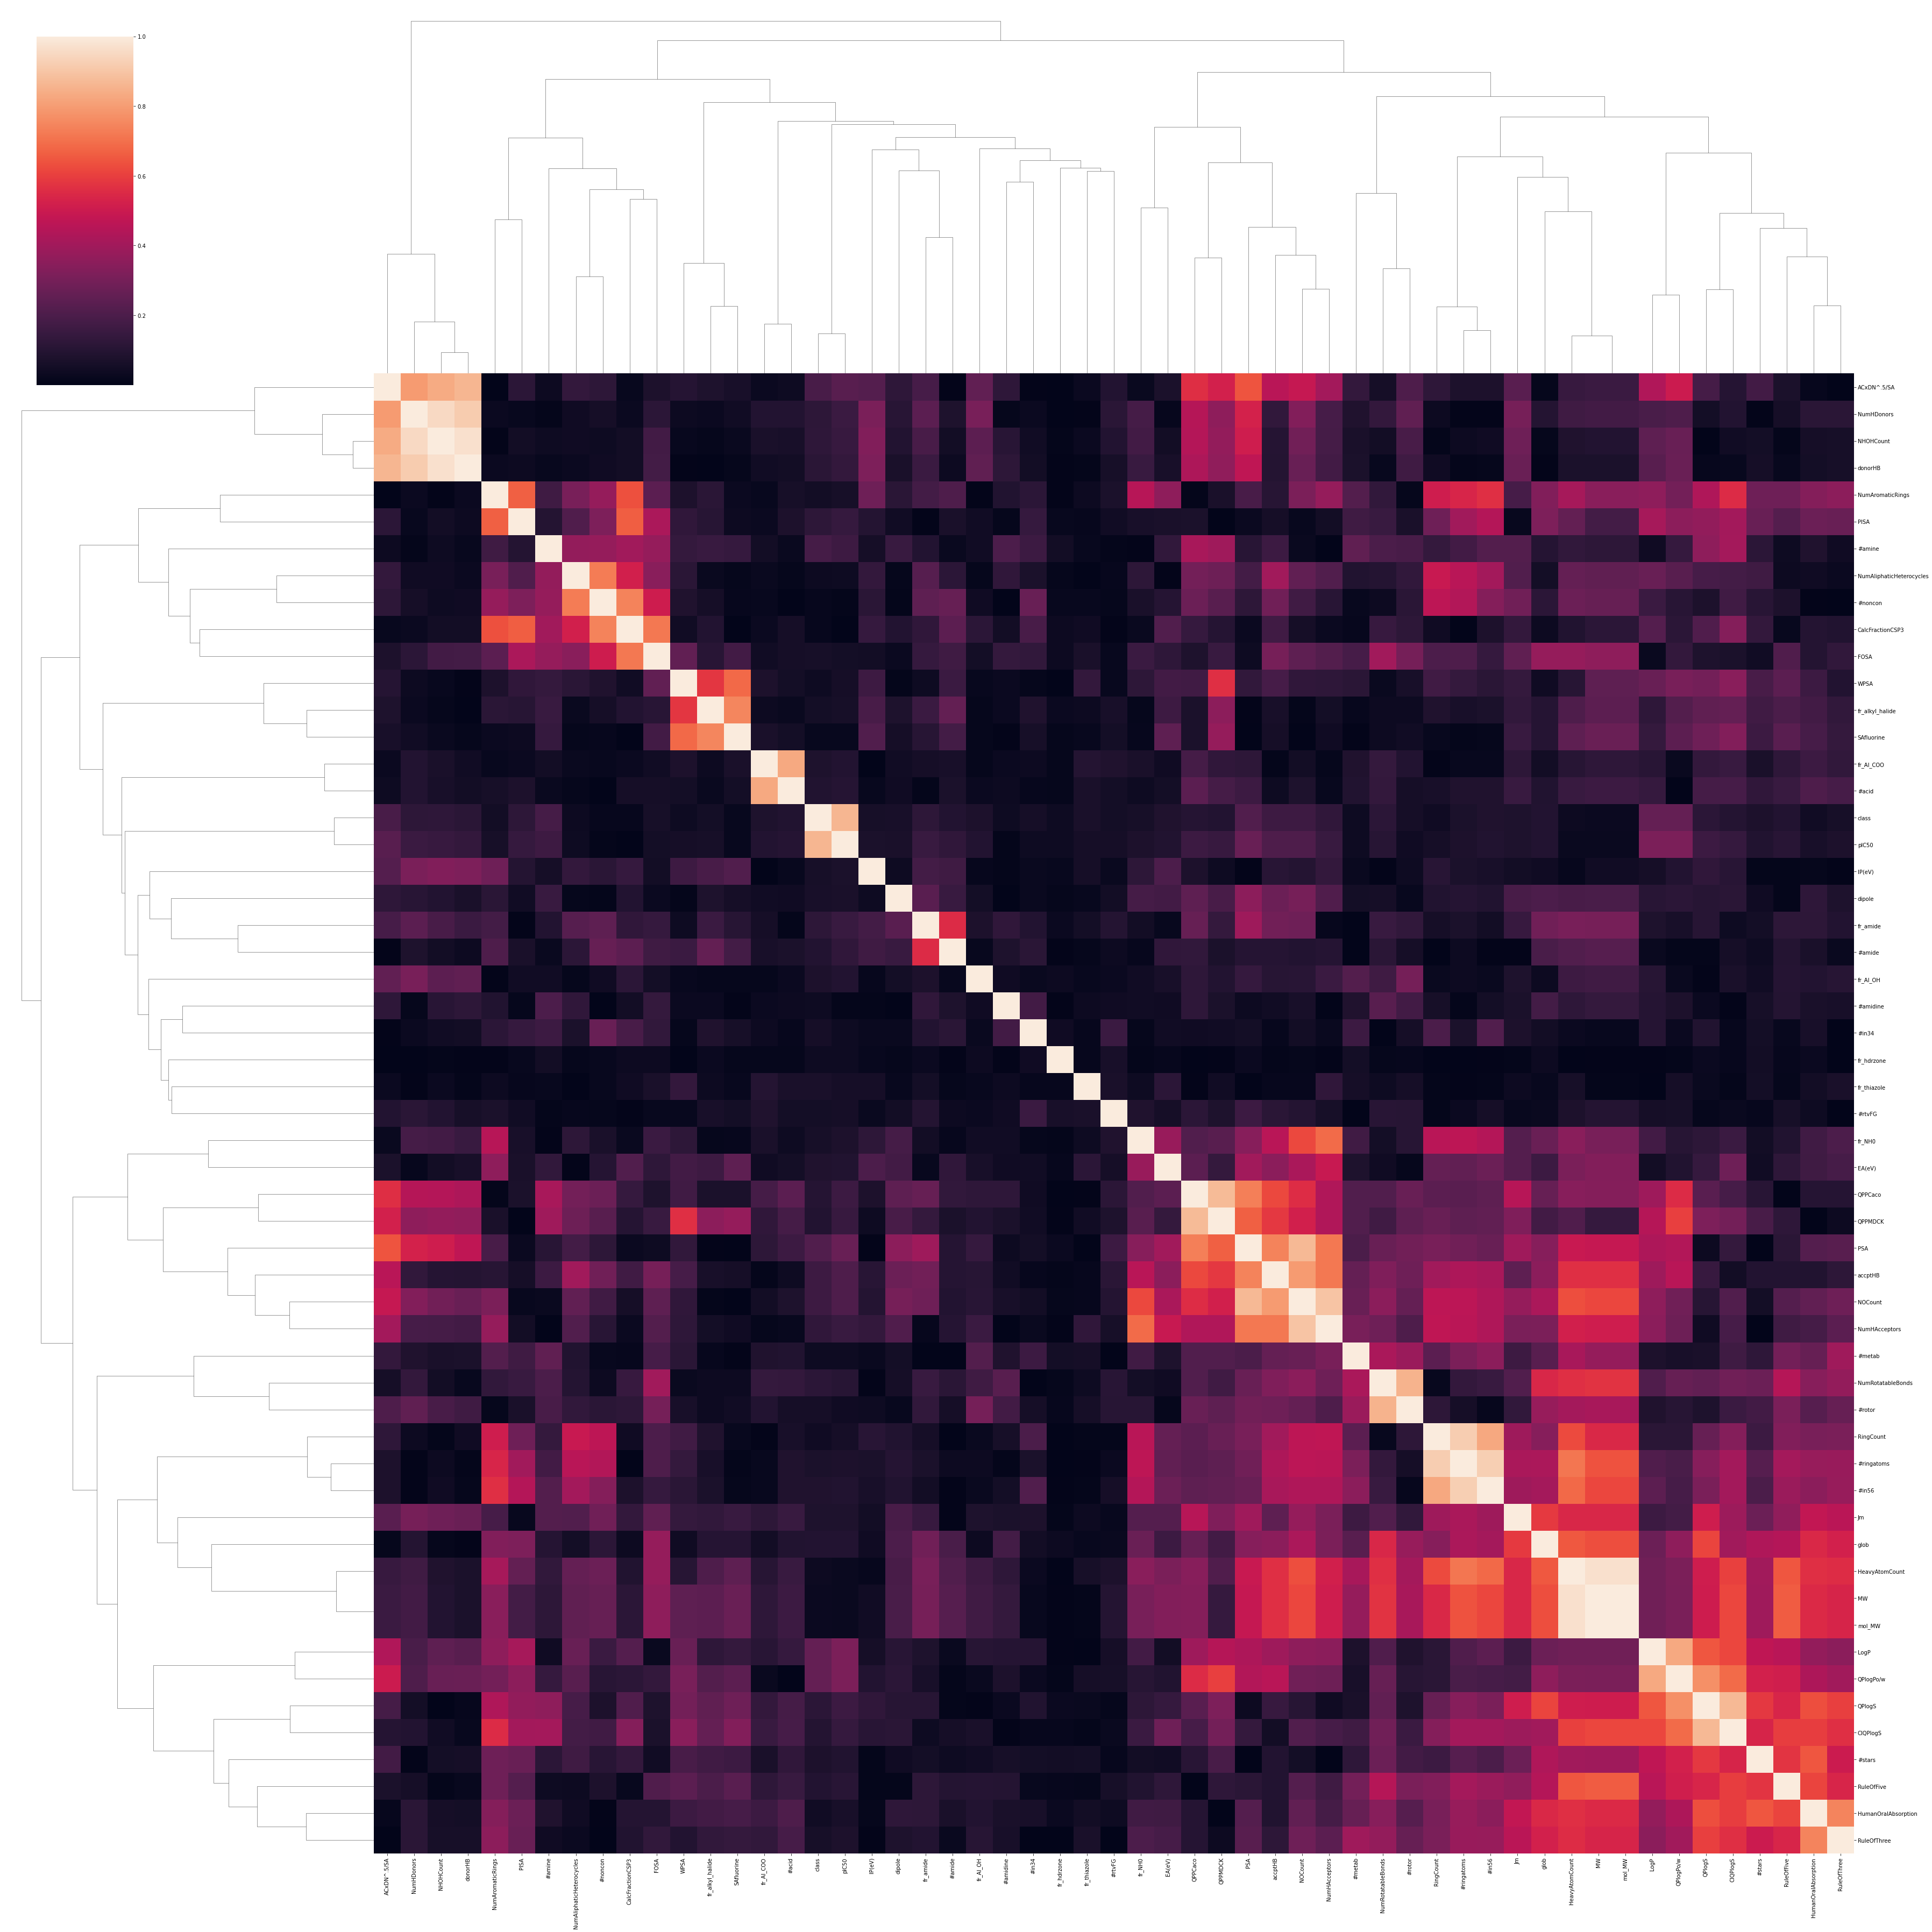

In [1256]:
#plt.figure(figsize=(15, 10))
sns.clustermap(np.abs(corr_df_spearman), annot = False, figsize=(50, 50))

Принципально новых корреляций не выявлено

In [1257]:
Dict, index, df_all_without_corrs = delete_correlations(df_all1, corr_df_spearman, 0.80)

Deleted fearures are: Index(['HeavyAtomCount', 'NumHDonors', 'NHOHCount', 'ACxDN^.5/SA', 'NOCount',
       'NumRotatableBonds', '#ringatoms', '#in56', '#acid', 'MW', 'QPlogPo/w',
       'CIQPlogS', 'QPPCaco', 'pIC50'],
      dtype='object')


In [1258]:
Dict

{'HeavyAtomCount': 'mol_MW corr = 0.9718515707425296',
 'NumHDonors': 'donorHB corr = 0.9154537431605784',
 'NHOHCount': 'donorHB corr = 0.9712976432859408',
 'ACxDN^.5/SA': 'donorHB corr = 0.8611425567279732',
 'NOCount': 'PSA corr = 0.8703215729986387',
 'NumRotatableBonds': '#rotor corr = 0.8552183161212784',
 '#ringatoms': '#in56 corr = 0.9255073349970032',
 '#in56': 'RingCount corr = 0.8243080430815548',
 '#acid': 'fr_Al_COO corr = 0.8317275397400602',
 'MW': 'mol_MW corr = 0.9999988443752955',
 'QPlogPo/w': 'LogP corr = 0.8283398199646842',
 'CIQPlogS': 'QPlogS corr = 0.8697771056843178',
 'QPPCaco': 'QPPMDCK corr = 0.8748969929487782',
 'pIC50': 'class corr = 0.8617059076557185'}

In [1259]:
df_all_without_corrs["pIC50"] = df_all["pIC50"]
del df_all_without_corrs["class"]
corr_df_spearman = df_all_without_corrs.corr(method="spearman")

corr_df_spearman[np.abs(corr_df_spearman['pIC50']) > 0.2]['pIC50']

LogP       0.314824
accptHB   -0.206469
PSA       -0.267689
pIC50      1.000000
Name: pIC50, dtype: float64

In [1260]:
df_x = df_all_without_corrs.drop(['pIC50'], axis =1)

In [1261]:
df_x.astype(float)

,NumHAcceptors,NumAromaticRings,NumAliphaticHeterocycles,RingCount,fr_Al_COO,fr_Al_OH,fr_amide,fr_NH0,fr_alkyl_halide,fr_hdrzone,fr_thiazole,CalcFractionCSP3,LogP,#stars,#amine,#amidine,#amide,#rotor,#rtvFG,mol_MW,dipole,FOSA,PISA,WPSA,donorHB,accptHB,glob,QPlogS,QPPMDCK,IP(eV),EA(eV),#metab,HumanOralAbsorption,SAfluorine,PSA,RuleOfFive,#in34,#noncon,RuleOfThree,Jm
0,2.0,1.0,1.0,2.0,0.0,0.0,1.0,1.0,3.0,0.0,0.0,0.562500,3.81890,0.0,1.0,0.0,0.0,4.0,0.0,348.795,4.503,270.702,95.102,136.790,1.0,4.50,0.873948,-3.541,2281.905,9.216,0.830,1.0,3.0,106.720,36.352,0.0,0.0,4.0,0.0,0.014
1,2.0,1.0,1.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.533333,3.45350,1.0,1.0,0.0,0.0,4.0,0.0,315.242,3.837,272.846,100.553,117.679,1.0,4.50,0.873163,-3.187,1971.044,9.155,0.539,0.0,3.0,0.000,36.488,0.0,0.0,4.0,0.0,0.035
2,2.0,1.0,1.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.533333,2.93920,1.0,1.0,0.0,0.0,4.0,0.0,298.787,4.618,275.614,109.554,90.761,1.0,4.50,0.875896,-2.872,1283.840,9.150,0.587,0.0,3.0,22.391,37.281,0.0,0.0,4.0,0.0,0.063
3,2.0,1.0,1.0,2.0,0.0,0.0,1.0,1.0,3.0,0.0,0.0,0.562500,3.30460,0.0,1.0,0.0,0.0,4.0,0.0,332.340,6.091,306.041,108.949,111.696,1.0,4.50,0.851802,-3.712,2014.895,8.934,0.943,1.0,3.0,111.696,34.625,0.0,0.0,4.0,0.0,0.014
4,2.0,1.0,1.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.562500,3.10852,0.0,1.0,0.0,0.0,4.0,0.0,294.823,4.098,315.309,105.348,61.643,1.0,4.50,0.888490,-2.788,974.521,9.179,0.242,1.0,3.0,0.000,36.719,0.0,0.0,4.0,0.0,0.086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7435,5.0,2.0,3.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.538462,2.26970,0.0,1.0,0.0,0.0,0.0,0.0,323.192,4.539,257.112,115.706,77.824,0.0,5.50,0.870498,-1.963,1165.463,8.778,0.665,2.0,3.0,0.000,41.964,0.0,0.0,7.0,0.0,0.271
7436,4.0,3.0,2.0,5.0,0.0,0.0,1.0,4.0,0.0,0.0,0.0,0.437500,5.10274,3.0,1.0,0.0,0.0,5.0,0.0,512.694,8.241,376.095,406.033,0.000,0.0,6.00,0.790389,-7.170,285.724,8.733,0.903,6.0,1.0,0.000,52.714,2.0,0.0,10.0,1.0,0.000
7437,3.0,3.0,2.0,5.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.406250,6.60084,3.0,1.0,0.0,0.0,4.0,0.0,481.680,4.979,342.920,449.745,0.000,0.0,4.50,0.796824,-7.519,773.024,8.152,0.022,4.0,1.0,0.000,30.046,1.0,0.0,10.0,1.0,0.000
7438,4.0,2.0,0.0,2.0,0.0,0.0,0.0,1.0,3.0,0.0,1.0,0.125000,3.49040,1.0,0.0,0.0,0.0,2.0,0.0,250.256,6.673,0.983,123.806,202.711,2.0,2.00,0.887804,-3.497,9308.097,8.981,1.551,1.0,3.0,115.026,39.662,0.0,0.0,0.0,0.0,0.234


In [1262]:
#intermed = df_x["fr_hdrzone"]
#del df_x["SAFluorine"]

Анализ feature importance объединенных дескрипторов Шредингера и структрных+физико-химических

In [1263]:
Yc = df_all["class"]
X = df_x

X_train, X_test, y_train, y_test = train_test_split(X, Yc, shuffle=True, random_state=75, train_size=.8)

In [1264]:
scaler = StandardScaler()
scaler.fit(X_train.values)
X_norm_SS = DataFrame(scaler.transform(X_train.values), index=X_train.index, columns=X_train.columns)
scaler.fit(df_val_d.values)
df_norm = DataFrame(scaler.transform(df_val_d.values), index=df_val_d.index, columns=df_val_d.columns)
scaler.fit(X_test.values)
X_norm_test = DataFrame(scaler.transform(X_test.values), index=X_test.index, columns=X_test.columns)

In [1265]:
feature_names = [f'feature {i}' for i in df_x.columns]
forest = RandomForestClassifier(random_state=0)
forest.fit(X_norm_SS, y_train)

RandomForestClassifier(random_state=0)

feature importance с permutation:

In [1266]:
start_time = time.time()
result = permutation_importance(
    forest, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: "
      f"{elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_names)

Elapsed time to compute the importances: 4.116 seconds


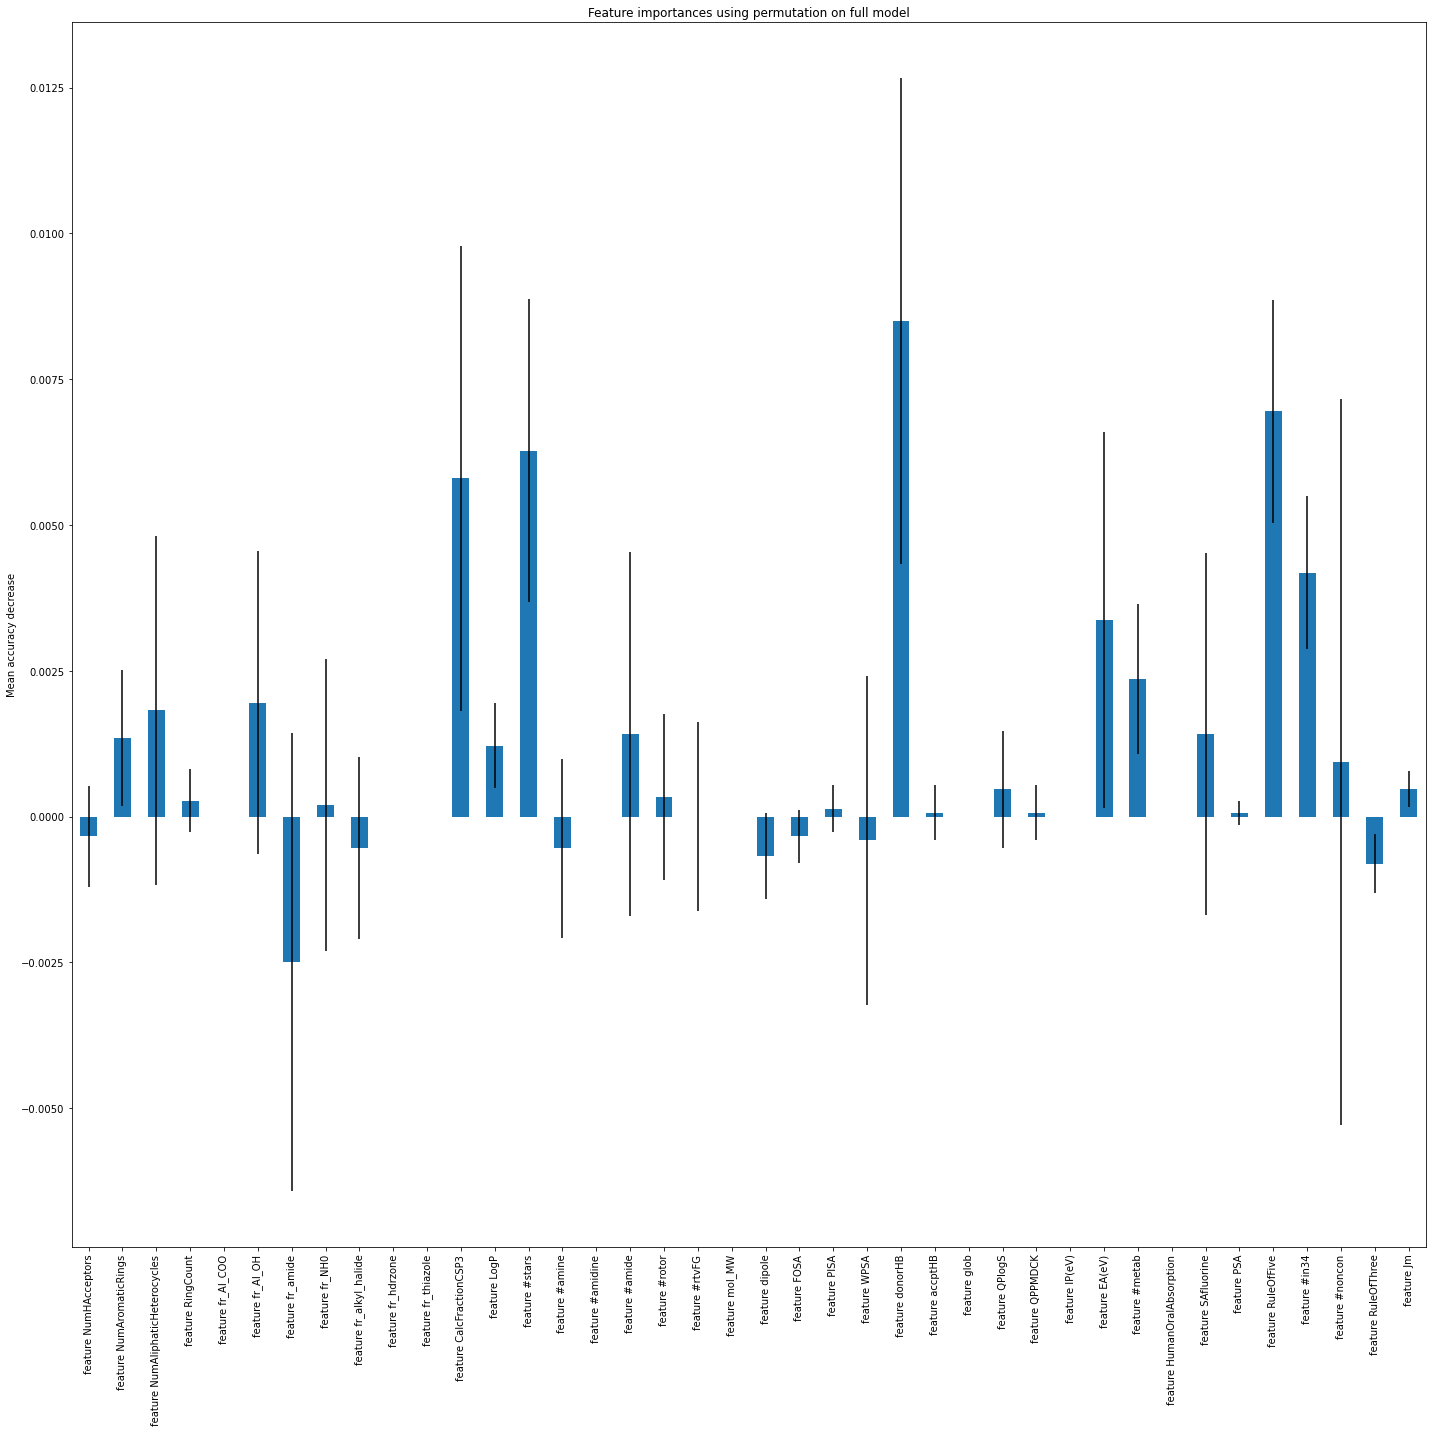

In [1267]:
fig, ax = plt.subplots(figsize=(20,20))
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

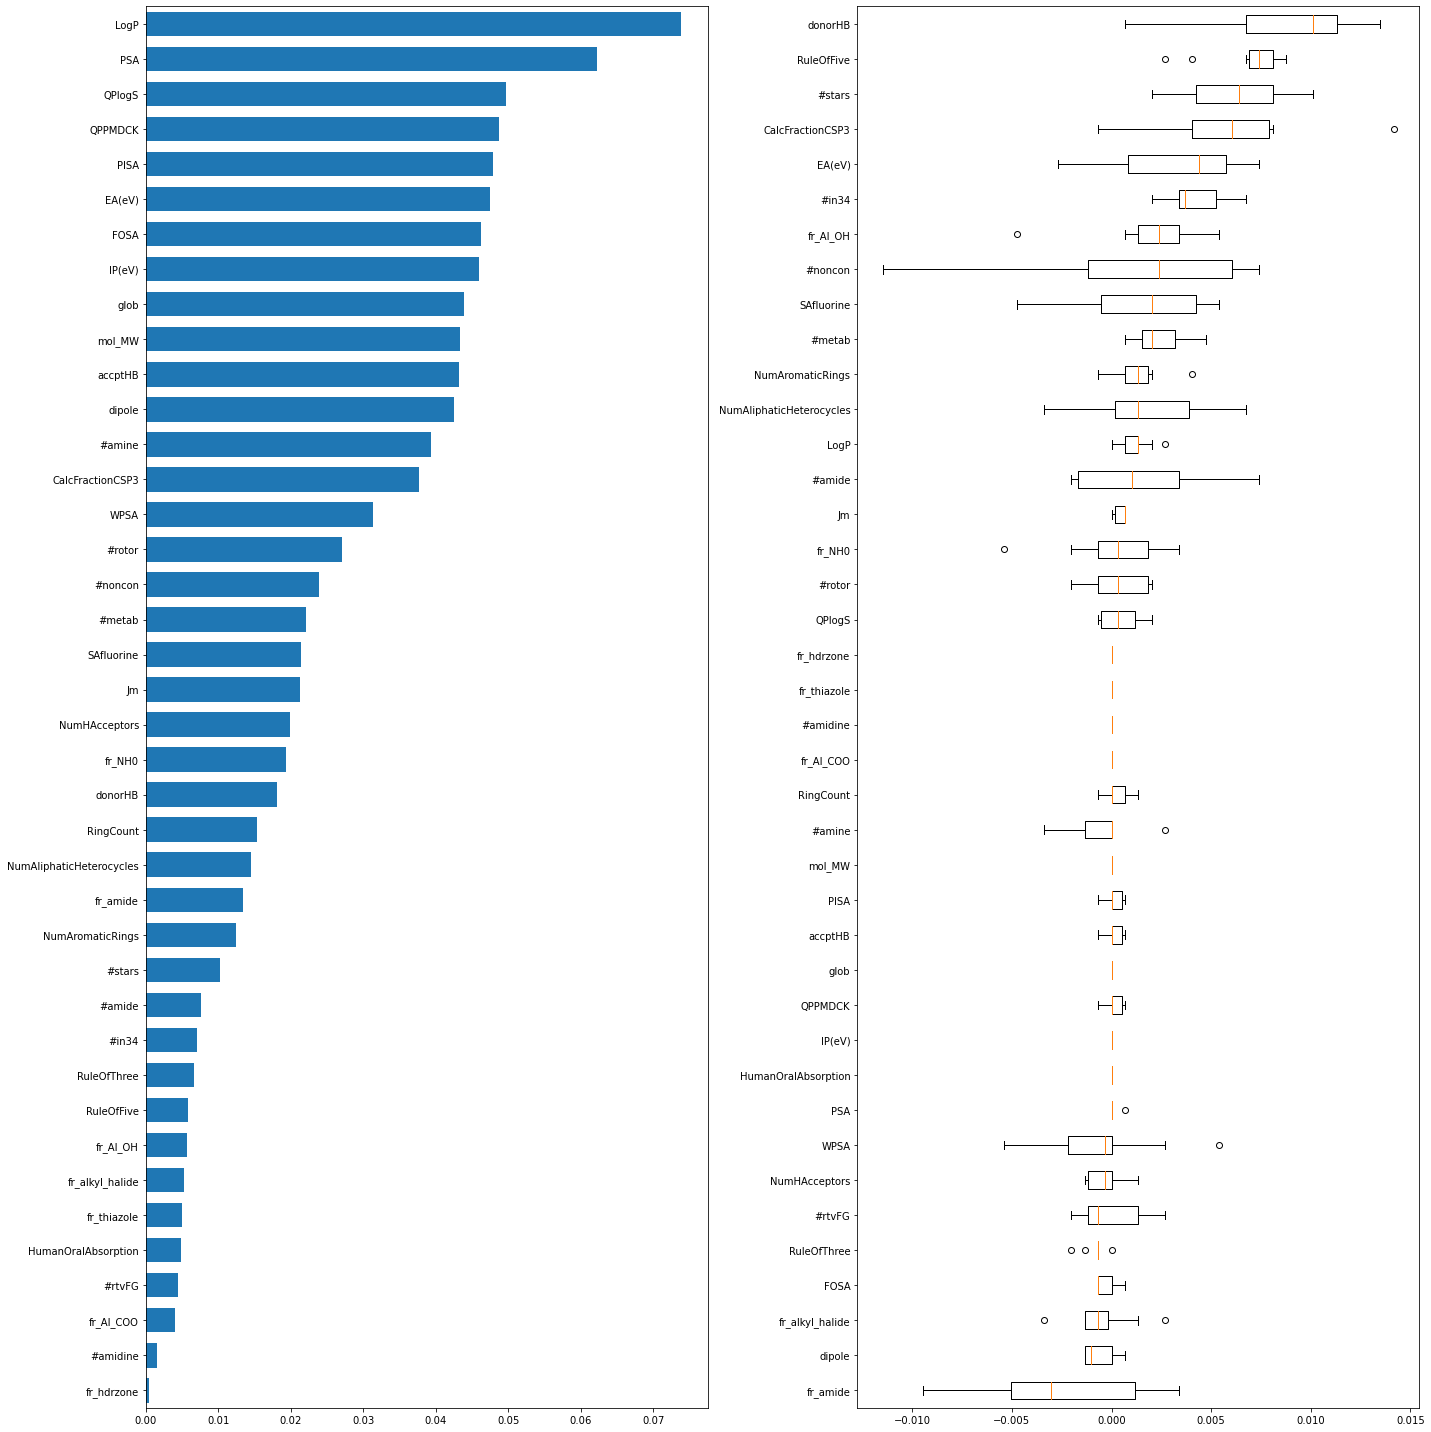

In [1268]:
#result = permutation_importance(clf, X_train, y_train, n_repeats=10, random_state=42)
perm_sorted_idx = np.median(result.importances, axis = 1).argsort()
tree_importance_sorted_idx = np.argsort(forest.feature_importances_)
tree_indices = np.arange(0, len(forest.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,20))
ax1.barh(tree_indices, forest.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticks(tree_indices)
ax1.set_yticklabels(df_x.columns[tree_importance_sorted_idx])
ax1.set_ylim((0, len(forest.feature_importances_)))
ax2.boxplot(
    result.importances[perm_sorted_idx].T,
    vert=False,
    labels=df_x.columns[perm_sorted_idx],
)
fig.tight_layout()
plt.savefig('feature_importance_Schrodinger_070.png')
plt.show()

In [1271]:
forest_importances = pd.DataFrame(forest_importances)
forest_importances = forest_importances.apply(np.abs)
forest_importances = forest_importances.sort_values(by=[0], ascending=False)
forest_importances.head(30)

,0
feature donorHB,0.008502
feature RuleOfFive,0.006950
feature #stars,0.006275
feature CalcFractionCSP3,0.005803
feature #in34,0.004184
feature EA(eV),0.003374
feature fr_amide,0.002497
feature #metab,0.002362
feature fr_Al_OH,0.001957
feature NumAliphaticHeterocycles,0.001822


In [1270]:
np.argmax(result.importances_std)

37

In [1272]:
result.importances_std[37]

0.006222478749472866

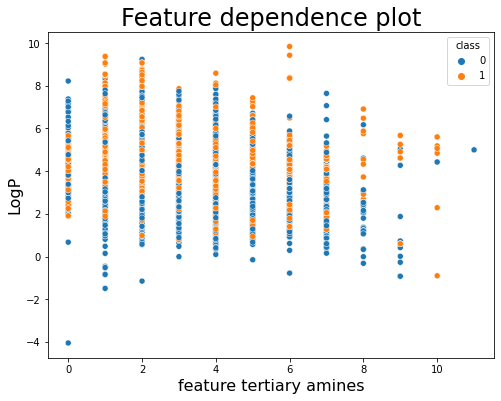

In [1273]:
plt.figure(figsize=(8, 6))
plt.title('Feature dependence plot', size=24)
plt.xlabel('feature tertiary amines', size=16)
plt.ylabel('LogP', size=16)

sns.scatterplot(x=df_x["fr_NH0"],
                y=df_x["LogP"], 
                hue= df_all['class']);
plt.savefig("LogP_fr_NH0.png")

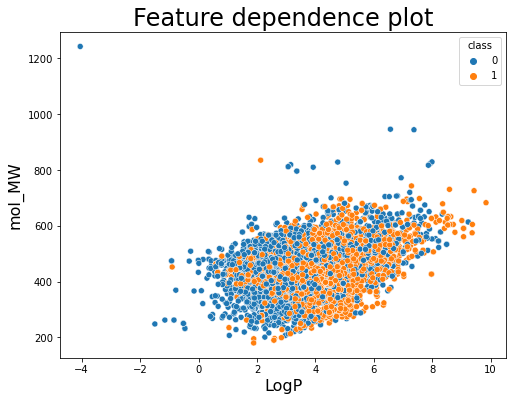

In [1274]:
plt.figure(figsize=(8, 6))
plt.title('Feature dependence plot', size=24)
plt.xlabel('LogP', size=16)
plt.ylabel('mol_MW', size=16)
sns.scatterplot(x=df_x["LogP"],
                y=df_x["mol_MW"], 
                hue= df_all['class']);
plt.savefig("LogP_MW.png")

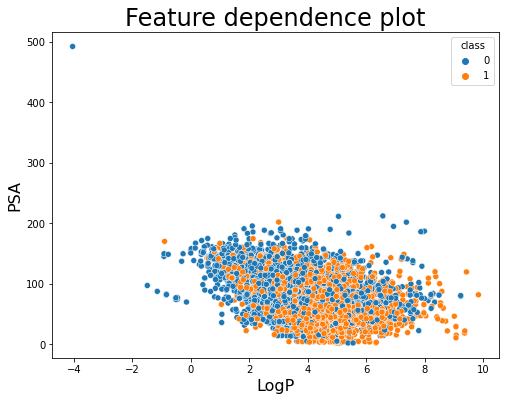

In [1275]:
plt.figure(figsize=(8, 6))
plt.title('Feature dependence plot', size=24)
plt.xlabel('LogP', size=16)
plt.ylabel('PSA', size=16)
sns.scatterplot(x=df_x["LogP"],
                y=df_x["PSA"], 
                hue= df_all['class']);
plt.savefig("LogP_PSA.png")

In [63]:
# d_schroedinger.dtypes

In [40]:
df_x

NameError: name 'df_x' is not defined

In [1323]:
df_x1 = df_x[["LogP",'dipole', 'PSA', 'glob', "#noncon", "#rotor", "CalcFractionCSP3", "mol_MW"]]
df_x2 = df_x[["LogP",'PSA', "CalcFractionCSP3", "mol_MW"]]

In [1277]:
#df_val_1 = df_val[["LogP", #amine",'dipole', 'PISA', 'glob']]

In [1324]:
Yc = df_all["class"]
X = df_x2
X_train, X_test, y_train, y_test = train_test_split(X, Yc, shuffle=True, random_state=75, train_size=.8)

In [1325]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'log2']
# Maximum number of levels in tree
max_depth = [3, 4, 5]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'log2'], 'max_depth': [3, 4, 5, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [1326]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(df_x, df_all["class"])

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [3, 4, 5, None],
                                        'max_features': ['auto', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [1328]:
rf_random.best_params_

{'n_estimators': 1000,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': None,
 'bootstrap': True}

In [1301]:
params = {'n_estimators': 200,
     'min_samples_split': 2,
     'min_samples_leaf': 2,
     'max_features': 'log2',
     'max_depth': 5,
     'bootstrap': True}

In [1329]:
new_RF = RandomForestClassifier()
new_RF.set_params(**rf_random.best_params_)

RandomForestClassifier(max_features='log2', min_samples_split=10,
                       n_estimators=1000)

In [1330]:
model1 = new_RF.fit(df_x2, df_all["class"])

In [1319]:
df_x1.columns

Index(['LogP', 'dipole', 'PSA', 'glob', '#noncon', '#rotor',
       'CalcFractionCSP3', 'mol_MW'],
      dtype='object')

In [1306]:
#! pip install graphviz

In [1307]:
model1.estimators_[0]

DecisionTreeClassifier(max_depth=5, max_features='log2', min_samples_leaf=2,
                       random_state=1576887403)

In [1308]:
df_all['class_str'] = df_all['class'].astype(str)

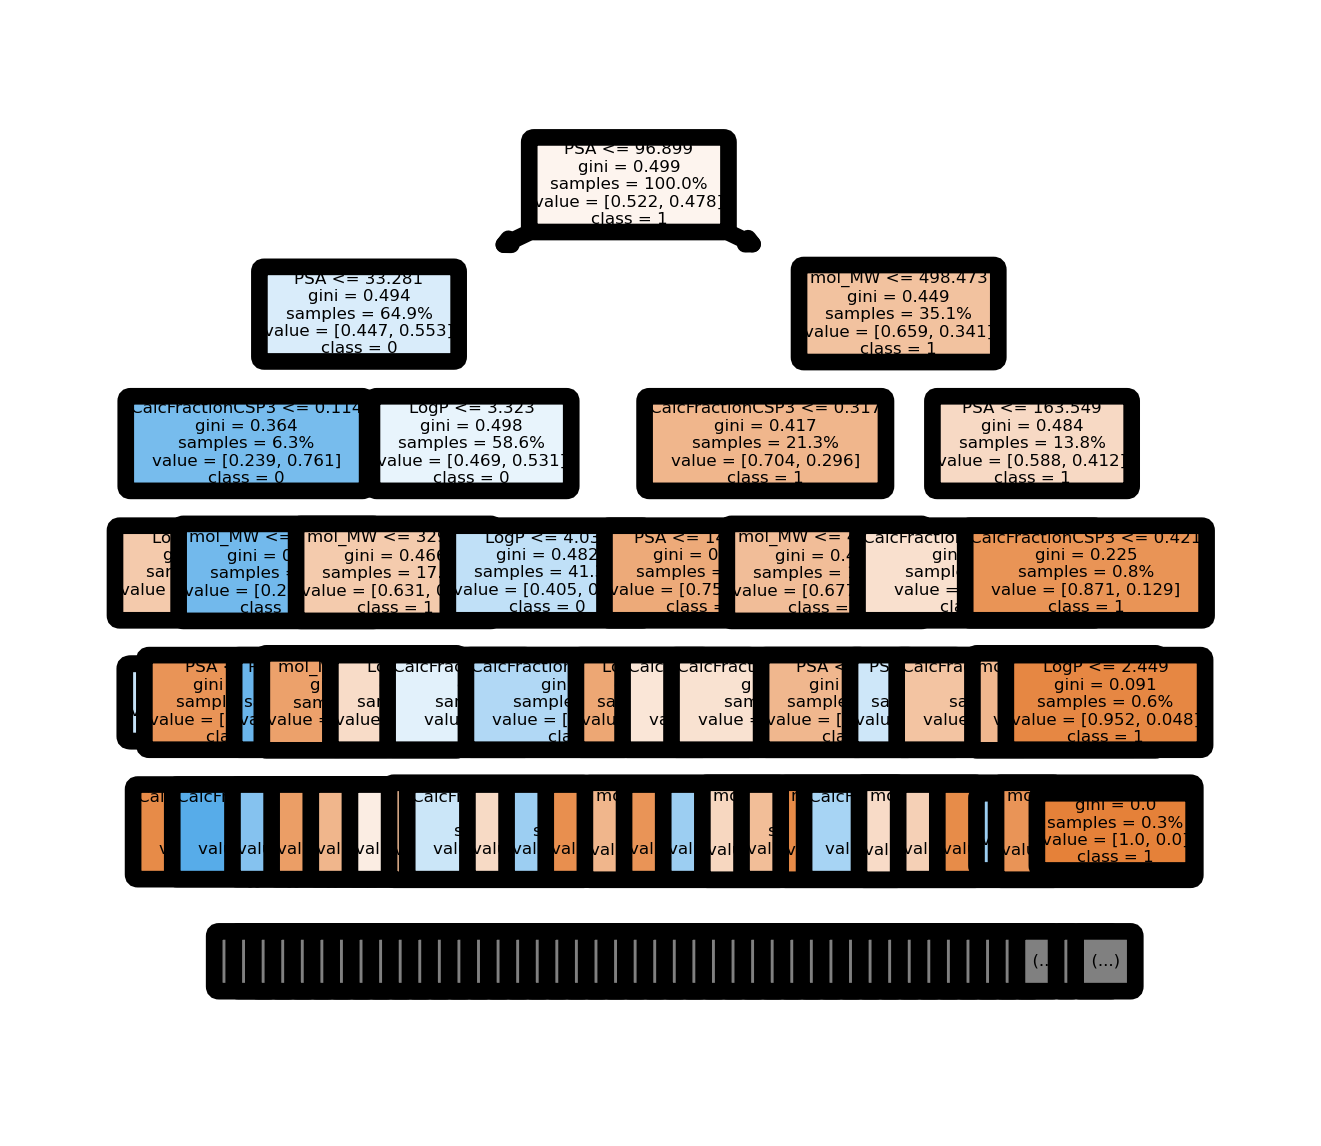

In [1332]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (1,1), dpi=1200)
plot_tree(model1.estimators_[0], 
          feature_names=df_x2.columns,
          class_names=df_all["class_str"], 
          filled=True, impurity=True, 
          rounded=True, proportion=True, max_depth = 5)
fig.savefig('imagename_tree.png')

In [1335]:
model1 = new_RF.fit(X_train, y_train)

In [1336]:
def print_metrics(y_test, X_test, clf):
    y_testf1 = np.transpose((np.array(y_test)).astype(np.int64))
    zt = clf.predict(X_test).astype(np.int64)
    print(f"roc auc test_set = {roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])}")
    print(f"bac test_set = {balanced_accuracy_score(y_test, clf.predict(X_test))}")
    print(f"acc test_set = {accuracy_score(y_test, clf.predict(X_test))}")
    print(f"f1_score ={f1_score(y_testf1, zt)}")
    print(f"recall_score ={recall_score(y_testf1, zt)}")
    print(f"precision_score ={precision_score(y_testf1, zt)}")

In [1338]:
res = print_metrics(y_test, X_test, model1)

roc auc test_set = 0.7426940050514195
bac test_set = 0.6699120482390444
acc test_set = 0.6727395411605938
f1_score =0.6415373244641537
recall_score =0.6262626262626263
precision_score =0.6575757575757576


Вывод
- В данном случае через feature importance (c permutation) было отобраны дескрипторы: ("LogP",'dipole', 'PSA', 'glob', "#noncon", "#rotor", "CalcFractionCSP3", "mol_MW"), которые. в то же время имеют корреляцию с pIC50.
- Проблема с переобучением модели по-прежнему остается. 
